In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,normalized_mutual_info_score, log_loss
from sklearn.linear_model import SGDClassifier,LogisticRegression
from collections import Counter,defaultdict
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold,train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB,MultinomialNB
import math
from sklearn.ensemble import RandomForestClassifier
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!gdown --id 1RmX5_q6D7rzoXD7nPUM_s8rKEf1KVMDi #training_text.zip download
!gdown --id 1bSQrw5WmDqqI8hBcr8Pflzatx4xCT0Ex #training_variants.zip download

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RmX5_q6D7rzoXD7nPUM_s8rKEf1KVMDi
To: /content/training_text.zip
100% 63.9M/63.9M [00:00<00:00, 179MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bSQrw5WmDqqI8hBcr8Pflzatx4xCT0Ex
To: /content/training_variants.zip
100% 24.8k/24.8k [00:00<00:00, 36.9MB/s]


In [ ]:
!unzip training_text.zip
!unzip training_variants.zip

Archive:  training_text.zip
  inflating: training_text           
Archive:  training_variants.zip
  inflating: training_variants       


In [ ]:
data_var=pd.read_csv('training_variants')
print("No of data points",data_var.shape[0])
print("No of features",data_var.shape[1])
print("Features",data_var.columns.values)
data_var.head()

No of data points 3321
No of features 4
Features ['ID' 'Gene' 'Variation' 'Class']


ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

In [ ]:
data_text=pd.read_csv('training_text',sep="\|\|",engine="python",names=['ID','Text'],skiprows=1)
print("No of data points",data_text.shape[0])
print("No of features",data_text.shape[1])
print("Features",data_text.columns.values)
data_text.head()

No of data points 3321
No of features 2
Features ['ID' 'Text']


ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

In [ ]:
import nltk
nltk.download('stopwords')
Stopwords=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def nlp_preprocessing(text,index,column):
  if(type(text) is not int):
    string=" "
    #replace every char with space
    text=re.sub('[^a-zA-Z0-9\n]',' ',text)
    #replace multispaces wtih single space
    text=re.sub('\s+',' ',text)
    #converting text to lower
    text=text.lower()
    for word in text.split():
      #removing stopword
      if word not in Stopwords:
        string+=word+" "
    data_text[column][index]=string


In [ ]:
# text
import time
start=time.time()
for index,row in data_text.iterrows():
  #print(index," ", row)
  if(type(row['Text']) is str):
    nlp_preprocessing(row['Text'],index,'Text')
  else:
    print("No text in id",index)
print("time taken",time.time()-start)

No text in id 1109
No text in id 1277
No text in id 1407
No text in id 1639
No text in id 2755
time taken 36.583274841308594


In [ ]:
data=pd.merge(data_var,data_text,on="ID",how="left")
data.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                Text  
0   cyclin dependent kinases cdks regulate variet...  
1   abstract background non small cell lung cance...  
2   abstract background non small cell lung cance...  
3   recent evidence demonstrated acquired unipare...  
4   oncogenic mutations monomeric casitas b linea...

In [ ]:
data[data.isnull().any(axis=1)]
data.loc[data['Text'].isnull(),'Text']=data['Gene']+" "+data["Variation"]
data[data['ID']==1109]

ID   Gene Variation  Class          Text
1109  1109  FANCA    S1088F      1  FANCA S1088F

In [ ]:
#Splittinh train test cv data
y_true=data['Class'].values
data_gene=data.Gene.str.replace('\s+','_')
data_variation=data.Variation.str.replace('\s+','_')

xtrain,x_test,ytrain,y_test=train_test_split(data,y_true,stratify=y_true,test_size=0.2)
x_train,x_cv,y_train,y_cv=train_test_split(xtrain,ytrain,stratify=ytrain,test_size=0.2)

In [ ]:
print("No of data points in train",x_train.shape[0])
print("No of data points in cross validate",x_cv.shape[0])
print("No of data points in test",x_test.shape[0])

No of data points in train 2124
No of data points in cross validate 532
No of data points in test 665


In [ ]:
#plotting distribution of y i's
train_class_dist=x_train['Class'].value_counts().sort_index()
test_class_dist=x_test['Class'].value_counts().sort_index()
cv_class_dist=x_cv['Class'].value_counts().sort_index()

In [ ]:
def plot_dist_yi(dist,txt,d):
  txt=str(txt)
  my_colors='rgbkymc'
  dist.plot(kind='bar')
  plt.xlabel("Class")
  plt.ylabel("Data points per class")
  plt.title("Distribution of yi's in "+txt+" data")
  plt.grid()
  plt.show()
  sorted_yi=np.argsort(dist.values)
  for i in sorted_yi:
    print('Number of data points in class', i+1, ':',dist.values[i], '(', np.round((dist.values[i]/d.shape[0]*100), 3), '%)')

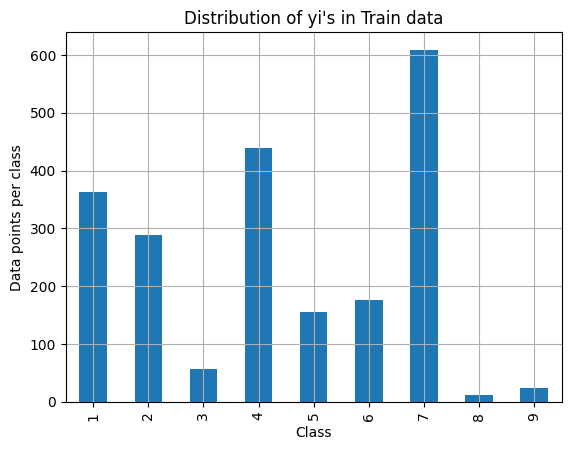

Number of data points in class 8 : 12 ( 0.565 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 7 : 609 ( 28.672 %)


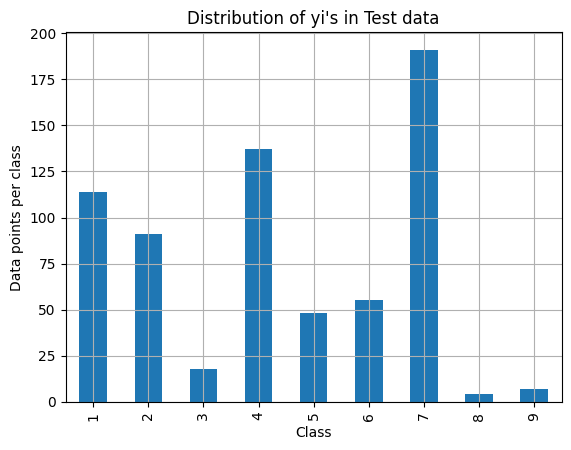

Number of data points in class 8 : 4 ( 0.602 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 7 : 191 ( 28.722 %)


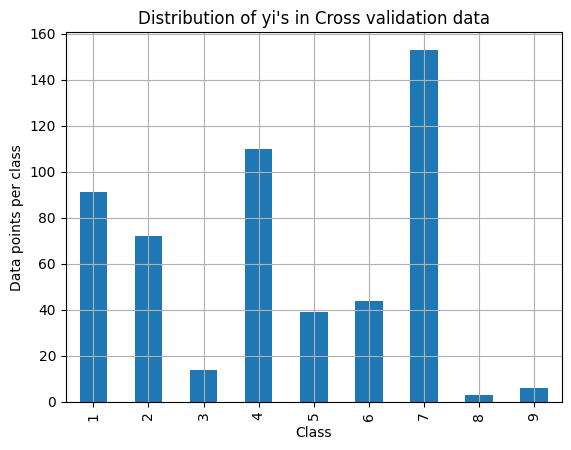

Number of data points in class 8 : 3 ( 0.564 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 7 : 153 ( 28.759 %)


In [ ]:
plot_dist_yi(train_class_dist,"Train",x_train)
plot_dist_yi(test_class_dist,"Test",x_test)
plot_dist_yi(cv_class_dist,"Cross validation",x_cv)

### **Random Model**

In [ ]:
#Plot confudsion matrix
def plot_confusion_matrix(y_test,y_predicted):
  c=confusion_matrix(y_test,y_predicted)
  b=(c/c.sum(axis=0))  #precision
  a=(((c.T)/(c.sum(axis=1))).T)

  labels=[1,2,3,4,5,6,7,8,9]

  print("Confusion Matrix")
  plt.figure(figsize=(20,7))
  sns.heatmap(c,annot=True,cmap='YlGnBu',fmt='.3f',xticklabels=labels,yticklabels=labels)
  plt.xlabel("Predicted Class")
  plt.ylabel("Original Claass")
  plt.show()

  print("Precision Matrix (Column sum=1)")
  plt.figure(figsize=(20,7))
  sns.heatmap(b,annot=True,cmap='YlGnBu',fmt='.3f',xticklabels=labels,yticklabels=labels)
  plt.xlabel("Predicted Class")
  plt.ylabel("Original Claass")
  plt.show()

  print("Recall Matrix (Row sum=1)")
  plt.figure(figsize=(20,7))
  sns.heatmap(a,annot=True,cmap='YlGnBu',fmt='.3f',xticklabels=labels,yticklabels=labels)
  plt.xlabel("Predicted Class")
  plt.ylabel("Original Claass")
  plt.show()


Log loss on Cross validation using Random model 2.5855291431186194
Log loss on Test using Random model 2.5105824416477884
Confusion Matrix


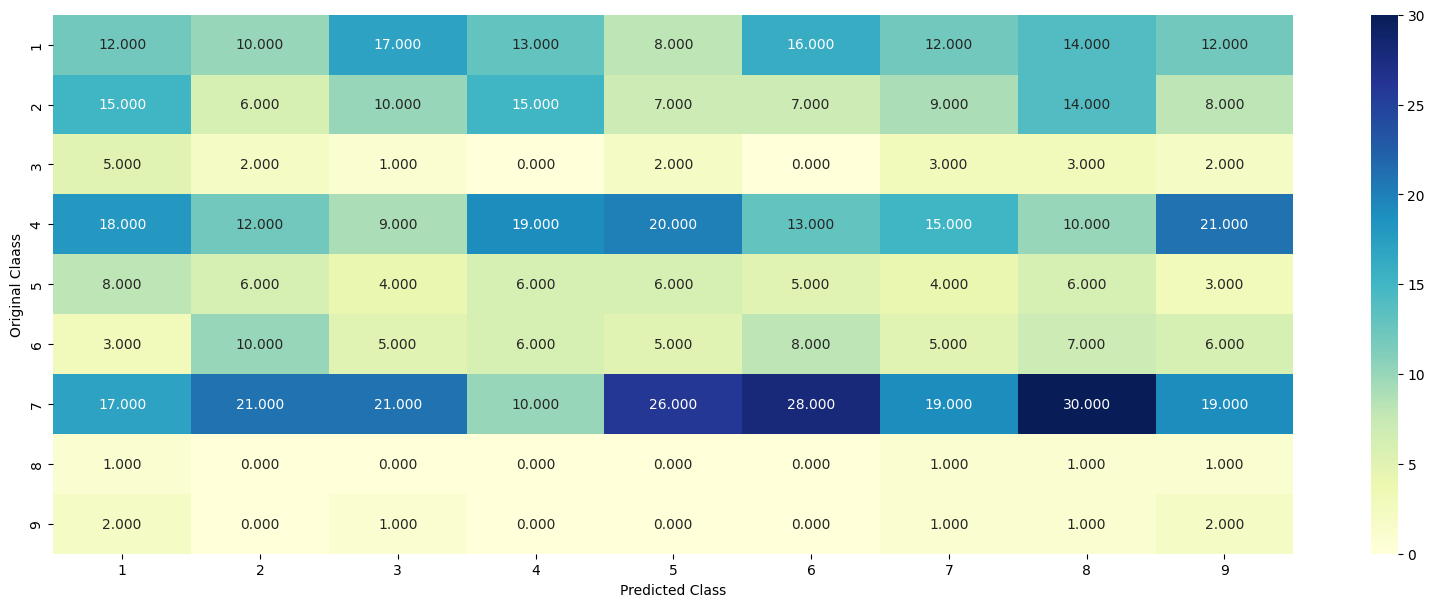

Precision Matrix (Column sum=1)


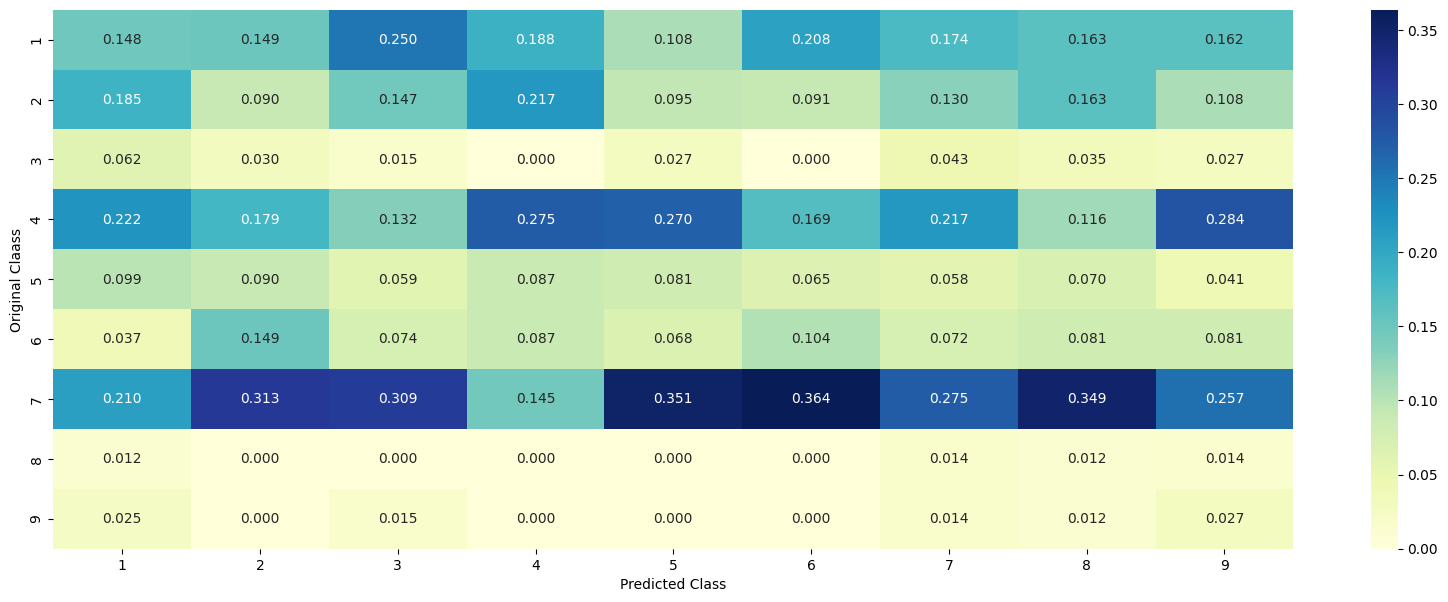

Recall Matrix (Row sum=1)


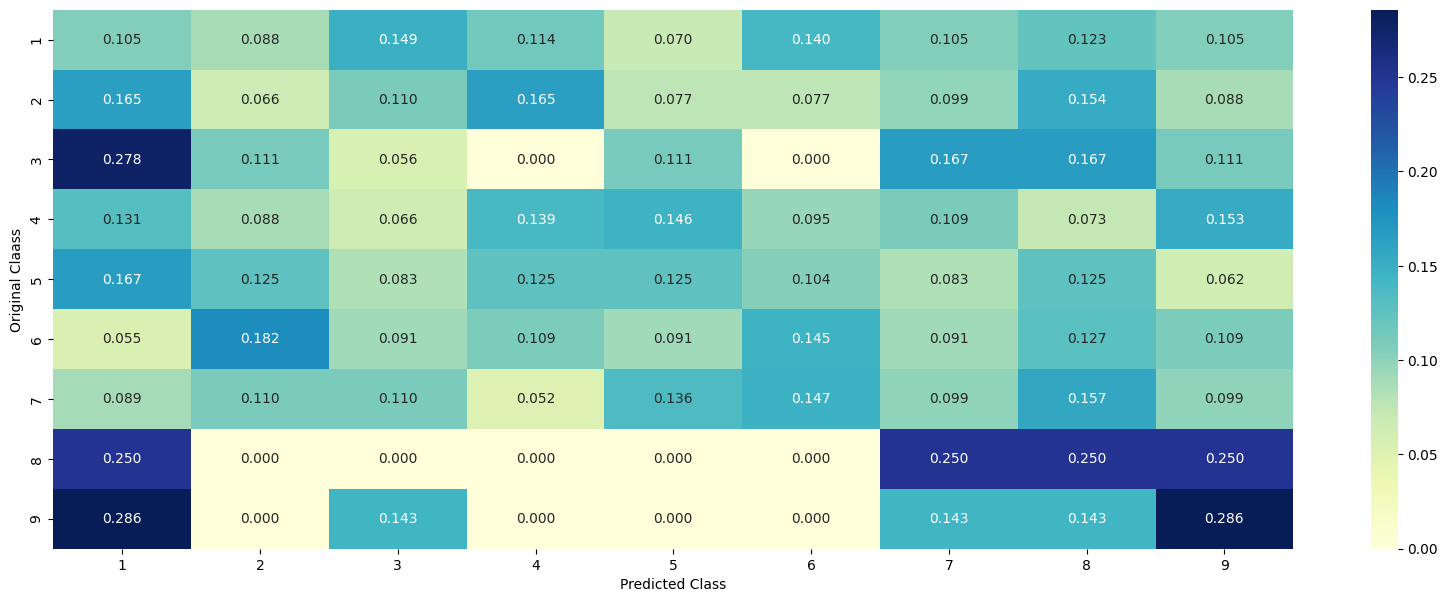

In [ ]:
test_data_len=x_test.shape[0]
cv_data_len=x_cv.shape[0]
cv_predicted=np.zeros((cv_data_len,9))
for i in range(cv_data_len):
  rand_probs=np.random.rand(1,9)
  cv_predicted[i]=(rand_probs/(rand_probs.sum(axis=1)))[0]
print("Log loss on Cross validation using Random model",log_loss(y_cv,cv_predicted,eps=1e-15))

test_predicted=np.zeros((test_data_len,9))
for i in range(test_data_len):
  rand_probs=np.random.rand(1,9)
  test_predicted[i]=(rand_probs/(rand_probs.sum(axis=1)))[0]
print("Log loss on Test using Random model",log_loss(y_test,test_predicted,eps=1e-15))

y_predicted=np.argmax(test_predicted,axis=1)
plot_confusion_matrix(y_test,y_predicted+1)

### **Univariate Analysis : Gene Feature**

In [ ]:
#code for response coding
def get_gv_fea_dict(alpha,feature,df):
  value_count=x_train[feature].value_counts()
  gv_dict=dict()
  for i,denominator in value_count.items():
    vec=[]
    for k in range(1,10):
      cls_cnt=x_train.loc[(x_train['Class']==k)&(x_train[feature]==i)]
      vec.append((cls_cnt.shape[0]+(alpha*10)/(denominator+(alpha*90))))
    gv_dict[i]=vec
  return gv_dict

def get_gv_feature(alpha,feature,df):
  gv_dict=get_gv_fea_dict(alpha,feature,df)
  value_count=x_train[feature].value_counts()
  gv_fea=[]
  for index,row in df.iterrows():
    if row[feature] in dict(value_count).keys():
      gv_fea.append(gv_dict[row[feature]])
    else:
      gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
  return gv_fea

### **How many categories are there and how they are distributed**

In [ ]:
def univariate_analysis(train,feature):
  unique_genes=train[feature].value_counts()
  print("No of unique genes: ",unique_genes.shape[0])
  print(unique_genes.head())

  #for distribution
  s=sum(unique_genes.values)
  h=unique_genes.values/s
  plt.plot(h,label="histogram of "+feature)
  plt.xlabel("Index of "+feature)
  plt.ylabel("No of occurence")
  plt.legend()
  plt.grid()
  plt.show()

  c=np.cumsum(h)
  plt.plot(c,label="CDF of "+feature)
  plt.legend()
  plt.grid()
  plt.show()

No of unique genes:  225
BRCA1    168
TP53     115
EGFR      91
BRCA2     81
PTEN      71
Name: Gene, dtype: int64


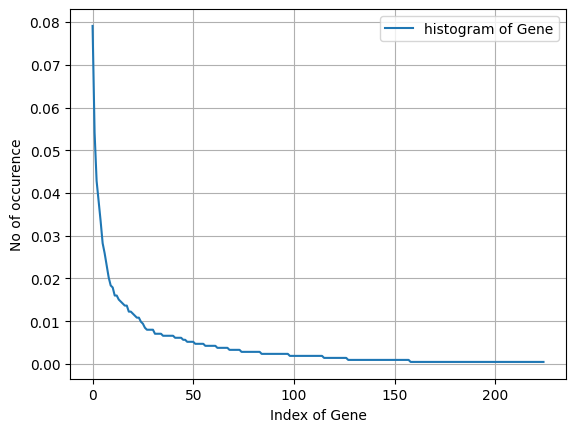

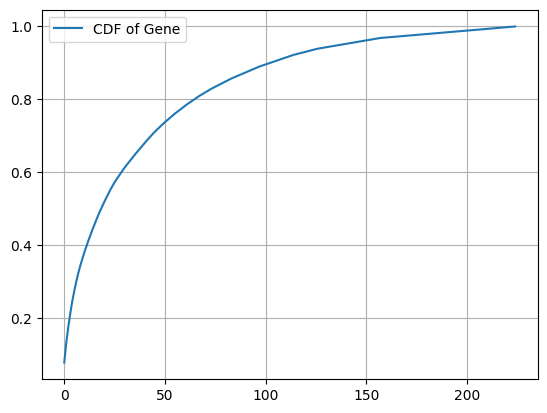

In [ ]:
univariate_analysis(x_train,'Gene')

Q] How to featurize gene feature?

Ans One hot encoding and Response coding

In [ ]:
alpha=1
train_gene_rc=np.array(get_gv_feature(alpha,'Gene',x_train))
test_gene_rc=np.array(get_gv_feature(alpha,'Gene',x_test))
cv_gene_rc=np.array(get_gv_feature(alpha,'Gene',x_cv))

#ohe
gene_vectorizer=CountVectorizer()
train_gene_ohe=gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_ohe=gene_vectorizer.transform(x_test['Gene'])
cv_gene_ohe=gene_vectorizer.transform(x_cv['Gene'])

In [ ]:
type(train_gene_ohe)

scipy.sparse._csr.csr_matrix

Q2] How good is this gene in predicting yi?

Ans Many good ways best is to use a ML model using inly feature yi

In [ ]:
def predicting_y(alpha,loss,train,cv,test,ytrain,ycv,ytest,weight):
  cv_log_error=[]
  for i in alpha:
    clf=SGDClassifier(alpha=i,penalty='l2',class_weight=weight,loss=loss,random_state=42)
    clf.fit(train,ytrain)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train,ytrain)
    predict_y=sig_clf.predict_proba(cv)
    cv_log_error.append(log_loss(ycv,predict_y,labels=clf.classes_,eps=1e-15))
    print("For values of alpha: ",i," Log loss is: ",log_loss(ycv,predict_y,labels=clf.classes_,eps=1e-15))

  fig,ax=plt.subplots()
  ax.plot(alpha,cv_log_error,c='g')
  for i,txt in enumerate(np.round(cv_log_error)):
    ax.annotate((alpha[i],np.round(txt,3)),(alpha[i],cv_log_error[i]))
  plt.grid()
  plt.title("Cross Validation Error for each alpha")
  plt.xlabel("Alpha i's")
  plt.ylabel("Error measure")
  plt.show()

  best_alpha=alpha[np.argmin(cv_log_error)]
  clf=SGDClassifier(alpha=best_alpha,penalty='l2',class_weight=weight,loss=loss,random_state=42)
  clf.fit(train,ytrain)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train,ytrain)

  predict_y=sig_clf.predict_proba(train)
  print("For values of best alpha ",best_alpha," Train log loss is: ",log_loss(ytrain,predict_y,labels=clf.classes_,eps=1e-15))
  predict_y=sig_clf.predict_proba(cv)
  print("For values of best alpha ",best_alpha," Cross Validation log loss is: ",log_loss(ycv,predict_y,labels=clf.classes_,eps=1e-15))
  predict_y=sig_clf.predict_proba(test)
  print("For values of best alpha ",best_alpha," Test log loss is: ",log_loss(ytest,predict_y,labels=clf.classes_,eps=1e-15))

  predicted_y=sig_clf.predict(test)

  return predicted_y,best_alpha

For values of alpha:  1e-05  Log loss is:  1.2172652240495068
For values of alpha:  0.0001  Log loss is:  1.1915862037047213
For values of alpha:  0.001  Log loss is:  1.2341761041036268
For values of alpha:  0.01  Log loss is:  1.3365017093525642
For values of alpha:  0.1  Log loss is:  1.421798642293639
For values of alpha:  1  Log loss is:  1.4636580443214573


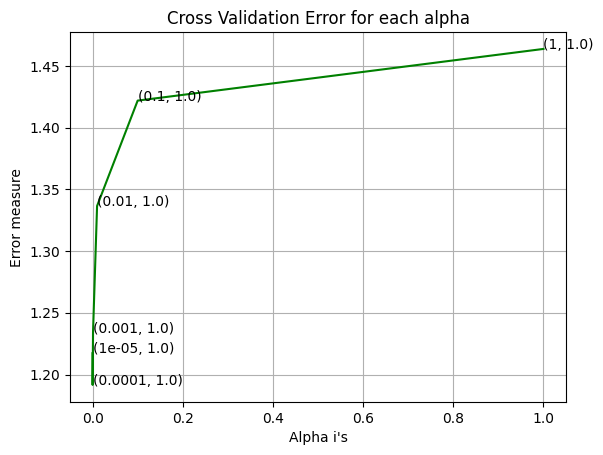

For values of best alpha  0.0001  Train log loss is:  1.0027282262203772
For values of best alpha  0.0001  Cross Validation log loss is:  1.1915862037047213
For values of best alpha  0.0001  Test log loss is:  1.1709490349294753


In [ ]:
alpha=[10**i for i in range(-5,1)]
predict_y,best_alpha=predicting_y(alpha,'log',train_gene_ohe,cv_gene_ohe,test_gene_ohe,y_train,y_cv,y_test,None)


Q3] Is Gene feature stable across all data set

Ans Yes it is otherwise cv&test error would be significantly more than train error.

In [ ]:
print("How many data points are covered by CV and test data are covered by Gene in train data?\nANS:")
test_coverage=x_test[x_test["Gene"].isin(list(set(x_train["Gene"])))].shape[0]
cv_coverage=x_cv[x_cv["Gene"].isin(list(set(x_train["Gene"])))].shape[0]

print("1. In Test data",test_coverage,"out of",x_test.shape[0],":",(test_coverage/len(x_test))*100)
print("2. In CV data",cv_coverage,"out of",x_cv.shape[0],":",(cv_coverage/len(x_cv))*100)

How many data points are covered by CV and test data are covered by Gene in train data?
ANS:
1. In Test data 632 out of 665 : 95.03759398496241
2. In CV data 512 out of 532 : 96.2406015037594


### **Univariate Analysis: Variation feature**

No of unique genes:  1945
Truncating Mutations    53
Deletion                45
Amplification           44
Fusions                 17
G12V                     3
Name: Variation, dtype: int64


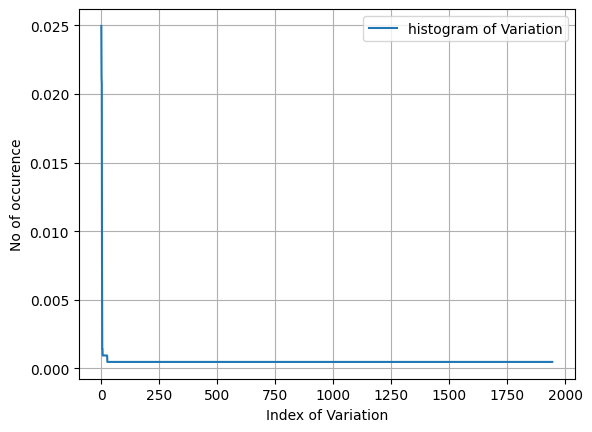

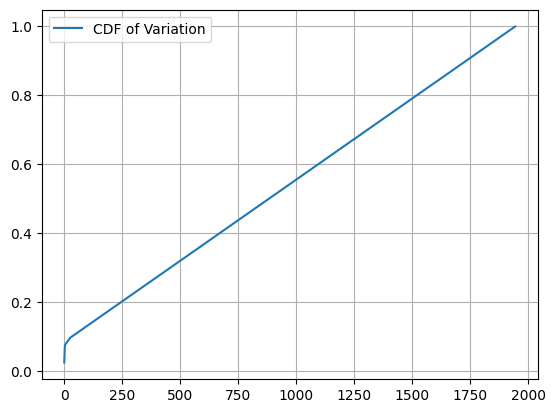

In [ ]:
#understanding categories and distribution
univariate_analysis(x_train,"Variation")

In [ ]:
#featurizing variation feature which is a categorical feature using response coding and one hot encoding
alpha=1
train_var_rc=np.array(get_gv_feature(alpha,'Variation',x_train))
test_var_rc=np.array(get_gv_feature(alpha,'Variation',x_test))
cv_var_rc=np.array(get_gv_feature(alpha,'Variation',x_cv))

#ohe
var_vectorizer=CountVectorizer()
train_var_ohe=var_vectorizer.fit_transform(x_train['Variation'])
test_var_ohe=var_vectorizer.transform(x_test['Variation'])
cv_var_ohe=var_vectorizer.transform(x_cv['Variation'])

For values of alpha:  1e-05  Log loss is:  1.6789249057174371
For values of alpha:  0.0001  Log loss is:  1.6743116975416907
For values of alpha:  0.001  Log loss is:  1.6834036779603607
For values of alpha:  0.01  Log loss is:  1.6943987886477914
For values of alpha:  0.1  Log loss is:  1.7139147611101984
For values of alpha:  1  Log loss is:  1.7159269275280837


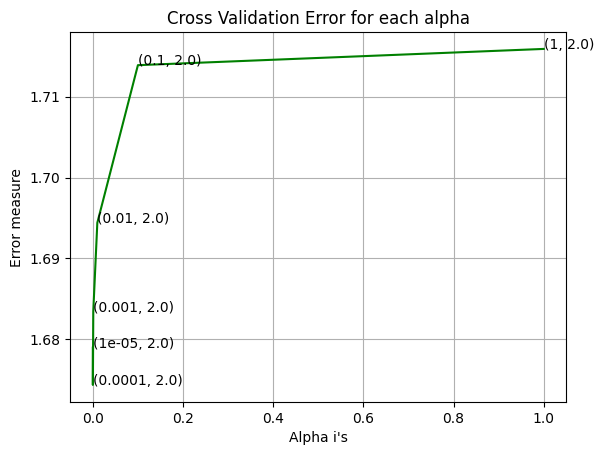

For values of best alpha  0.0001  Train log loss is:  0.7213166586877113
For values of best alpha  0.0001  Cross Validation log loss is:  1.6743116975416907
For values of best alpha  0.0001  Test log loss is:  1.675487231072414


In [ ]:
#Understanding how good is variation feature in predicting yi using Ml model
alpha=[10**i for i in range(-5,1)]
predict_y,best_alpha=predicting_y(alpha,'log',train_var_ohe,cv_var_ohe,test_var_ohe,y_train,y_cv,y_test,None)

In [ ]:
print("How many data points are covered by CV and test data are covered by Variation in train data?\nANS:")
test_coverage=x_test[x_test["Variation"].isin(list(set(x_train["Variation"])))].shape[0]
cv_coverage=x_cv[x_cv["Variation"].isin(list(set(x_train["Variation"])))].shape[0]

print("1. In Test data",test_coverage,"out of",x_test.shape[0],":",(test_coverage/len(x_test))*100)
print("2. In CV data",cv_coverage,"out of",x_cv.shape[0],":",(cv_coverage/len(x_cv))*100)

How many data points are covered by CV and test data are covered by Variation in train data?
ANS:
1. In Test data 85 out of 665 : 12.781954887218044
2. In CV data 56 out of 532 : 10.526315789473683


### **Univariate Analysis : Text feature**

In [ ]:
def extract_dict(cls_text):
  dictionary=defaultdict(int)
  for index,row in cls_text.iterrows():
    for word in row['Text'].split():
      dictionary[word]+=1
  return dictionary

#Building CountVectorizer with all words that occured min 3 times in train data
#ohe
text_vectorizer=CountVectorizer(min_df=3)
train_text_feature_ohe=text_vectorizer.fit_transform(x_train['Text'])
test_text_feature_ohe=text_vectorizer.transform(x_test['Text'])
cv_text_feature_ohe=text_vectorizer.transform(x_cv['Text'])

train_text_features=text_vectorizer.get_feature_names_out()
train_text_feat_count=train_text_feature_ohe.sum(axis=0).A1
text_fea_dict=dict(zip(list(train_text_features),train_text_feat_count))
print("Total No of unique words in train data ",len(train_text_features))

dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = x_train[x_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dict(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dict(x_train)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

#creating response coding for text features
def get_text_rc(df):
  text_feature_rc=np.zeros((df.shape[0],9))
  for i in range(0,9):
    row_index=0
    for index,row in df.iterrows():
      sum_prob=0
      for word in row["Text"].split():
        sum_prob+=math.log(((dict_list[i].get(word,0)+10)/(total_dict.get(word,0)+90)))
      text_feature_rc[row_index][i]=math.exp(sum_prob/len(row["Text"].split()))
      row_index+=1
  return text_feature_rc

Total No of unique words in train data  53226


In [ ]:
train_text_feature_rc=get_text_rc(x_train)
test_text_feature_rc=get_text_rc(x_test)
cv_text_feature_rc=get_text_rc(x_cv)

#normalize so that row sum is 1
train_text_feature_rc=((train_text_feature_rc.T)/train_text_feature_rc.sum(axis=1)).T
test_text_feature_rc=((test_text_feature_rc.T)/test_text_feature_rc.sum(axis=1)).T
cv_text_feature_rc=((cv_text_feature_rc.T)/cv_text_feature_rc.sum(axis=1)).T

#normalize ohe
train_text_feature_ohe=normalize(train_text_feature_ohe,axis=0)
test_text_feature_ohe=normalize(test_text_feature_ohe,axis=0)
cv_text_feature_ohe=normalize(cv_text_feature_ohe,axis=0)

sorted_text_fea_dict=dict(sorted(text_fea_dict.items(),key=lambda x:x[1],reverse=True))
sorted_text_occur=np.array(list(sorted_text_fea_dict.values()))
print(Counter(sorted_text_occur))

Counter({3: 4824, 4: 3722, 5: 3202, 6: 2695, 7: 2253, 8: 2023, 9: 1642, 10: 1475, 12: 1237, 11: 1211, 15: 1040, 14: 929, 13: 883, 16: 765, 18: 718, 20: 685, 24: 565, 21: 553, 17: 549, 19: 480, 22: 463, 35: 383, 32: 378, 28: 368, 23: 365, 26: 357, 27: 352, 30: 345, 25: 344, 46: 297, 36: 286, 29: 282, 40: 267, 33: 260, 37: 257, 31: 257, 34: 250, 39: 218, 42: 206, 38: 202, 45: 180, 56: 179, 41: 171, 44: 169, 48: 168, 50: 164, 49: 164, 43: 163, 60: 155, 55: 151, 51: 144, 47: 142, 53: 133, 70: 130, 57: 127, 52: 127, 64: 124, 58: 120, 63: 118, 54: 118, 66: 116, 74: 112, 65: 110, 61: 108, 59: 108, 62: 104, 75: 103, 71: 97, 72: 96, 81: 94, 80: 94, 92: 91, 68: 91, 69: 88, 78: 85, 73: 85, 67: 84, 76: 83, 88: 81, 84: 80, 77: 77, 87: 72, 79: 72, 90: 69, 96: 68, 110: 64, 91: 63, 85: 63, 98: 62, 101: 61, 93: 60, 120: 58, 83: 58, 97: 57, 95: 57, 86: 56, 105: 55, 104: 55, 99: 55, 94: 55, 89: 55, 108: 54, 128: 52, 111: 51, 106: 50, 102: 50, 124: 48, 82: 48, 107: 47, 116: 46, 112: 46, 115: 45, 103: 45, 

For values of alpha:  1e-05  Log loss is:  1.3539750727813689
For values of alpha:  0.0001  Log loss is:  1.2097688224393102
For values of alpha:  0.001  Log loss is:  1.1782741206941012
For values of alpha:  0.01  Log loss is:  1.3085488988376641
For values of alpha:  0.1  Log loss is:  1.5015440930080486
For values of alpha:  1  Log loss is:  1.6883298901758286


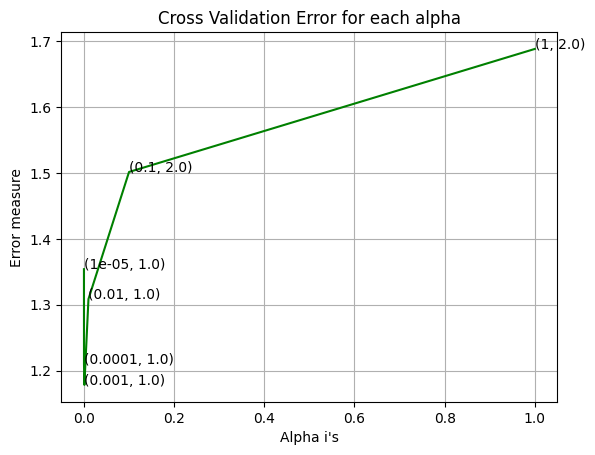

For values of best alpha  0.001  Train log loss is:  0.6707982335942583
For values of best alpha  0.001  Cross Validation log loss is:  1.1782741206941012
For values of best alpha  0.001  Test log loss is:  1.1227580272925555


In [ ]:
#Understanding how good is text feature in predicting yi using Ml model
alpha=[10**i for i in range(-5,1)]
predict_y=predicting_y(alpha,'log',train_text_feature_ohe,cv_text_feature_ohe,test_text_feature_ohe,y_train,y_cv,y_test,None)

In [ ]:
def get_intersec_text(df):
  df_text_vec=CountVectorizer(min_df=3)
  df_text_fea=df_text_vec.fit_transform(df['Text'])
  df_text_features=df_text_vec.get_feature_names_out()
  df_text_feature_count=df_text_fea.sum(axis=0).A1
  df_text_fea_dict=dict(zip(list(df_text_features),df_text_feature_count))
  len1=len(set(df_text_features))
  len2=len(set(train_text_features) & set(df_text_features))
  return len1,len2

In [ ]:
len1,len2=get_intersec_text(x_test)
print(np.round((len2/len1)*100,3),"% of word of test data appeared in train")
len1,len2=get_intersec_text(x_cv)
print(np.round((len2/len1)*100,3),"% of word of cv data appeared in train")

96.846 % of word of test data appeared in train
98.235 % of word of cv data appeared in train


### ML Model: Data Preparation

In [ ]:
def predict_plot_confusion_matrix(train_x,train_y,test_x,test_y,clf):
  clf.fit(train_x,train_y)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_x,train_y)
  pred_y=sig_clf.predict(test_x)
  predicted_y=sig_clf.predict_proba(test_x)
  print("log_loss: ",log_loss(test_y,predicted_y))
  print("No of mis classified points:",np.count_nonzero((pred_y-test_y))/test_y.shape[0])
  plot_confusion_matrix(test_y,pred_y)

def report_log_loss(train_x,train_y,test_x,test_y,clf):
  clf.fit(train_x,train_y)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_x,train_y)
  pred_y_prob=sig_clf.predict_proba(test_x)
  return log_loss(test_y,pred_y_prob,eps=1e-15)

In [ ]:
#Only for Naive Bayes
def get_impfeature_names(indices,text,gene,var,no_features):
  gene_count_vec=CountVectorizer()
  var_count_vec=CountVectorizer()
  text_count_vec=CountVectorizer()

  gene_vec=gene_count_vec.fit(x_train["Gene"])
  var_vec=var_count_vec.fit(x_train["Variation"])
  text_vec=text_count_vec.fit(x_train["Text"])

  fea1_len=len(gene_vec.get_feature_names_out())
  fea2_len=len(var_vec.get_feature_names_out())

  word_present=0
  for i,v in enumerate(indices):
    if(v<fea1_len):
      word=gene_vec.get_feature_names_out()[v]
      yes_no= True if word==gene else False

      if yes_no:
        word_present+=1
        print(i,"Gene feature [",word,"] present in test data point",yes_no)
    elif(v<(fea1_len+fea2_len)):
      word=var_vec.get_feature_names_out()[v-fea1_len]
      yes_no= True if word==var else False
      if yes_no:
        word_present+=1
        print(i,"Variation feature [",word,"] present in test data point",yes_no)

    else:
      word=text_vec.get_feature_names_out()[v-(fea1_len+fea2_len)]
      yes_no= True if word in text.split() else False

      if yes_no:
        word_present+=1
        print(i,"Text feature [",word,"] present in test data point",yes_no)
  print("Out of the top ",no_features," features ", word_present, "are present in query point")

# Stacking Features


In [ ]:
x_train_ohe=hstack((train_gene_ohe,train_var_ohe,train_text_feature_ohe)).tocsr()
x_test_ohe=hstack((test_gene_ohe,test_var_ohe,test_text_feature_ohe)).tocsr()
x_cv_ohe=hstack((cv_gene_ohe,cv_var_ohe,cv_text_feature_ohe)).tocsr()
print("ONE HOT ENCODING FEATURES:")
print("(Number of datapoints , Number of features) in train data",x_train_ohe.shape)
print("(Number of datapoints , Number of features) in test data",x_test_ohe.shape)
print("(Number of datapoints , Number of features) in cross validation data",x_cv_ohe.shape)

ONE HOT ENCODING FEATURES:
(Number of datapoints , Number of features) in train data (2124, 55422)
(Number of datapoints , Number of features) in test data (665, 55422)
(Number of datapoints , Number of features) in cross validation data (532, 55422)


In [ ]:
x_train_rc=np.hstack((train_gene_rc,train_var_rc,train_text_feature_rc))
x_test_rc=np.hstack((test_gene_rc,test_var_rc,test_text_feature_rc))
x_cv_rc=np.hstack((cv_gene_rc,cv_var_rc,cv_text_feature_rc))
print("RESPONSE ENCODING FEATURES:")
print("(Number of datapoints , Number of features) in train data",x_train_rc.shape)
print("(Number of datapoints , Number of features) in test data",x_test_rc.shape)
print("(Number of datapoints , Number of features) in cross validation data",x_cv_rc.shape)

RESPONSE ENCODING FEATURES:
(Number of datapoints , Number of features) in train data (2124, 27)
(Number of datapoints , Number of features) in test data (665, 27)
(Number of datapoints , Number of features) in cross validation data (532, 27)


## **Naive Bayes**

For alpha= 1e-05 Log loss is  1.3304521606331385
For alpha= 0.0001 Log loss is  1.3238240460007502
For alpha= 0.001 Log loss is  1.3149468260580277
For alpha= 0.01 Log loss is  1.3032855263748762
For alpha= 0.1 Log loss is  1.31368828404751
For alpha= 1 Log loss is  1.3401327631194362
For alpha= 10 Log loss is  1.4430863843478463
For alpha= 100 Log loss is  1.3730149031514767
For alpha= 1000 Log loss is  1.3377543228985964


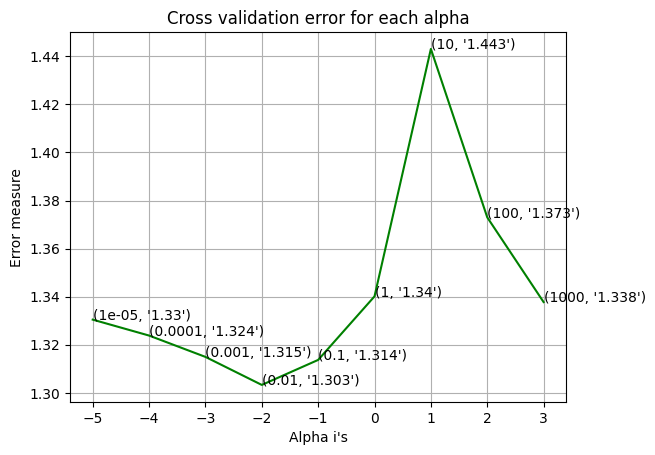

For best alpha= 0.01 Train Log loss is  0.869301546081382
For best alpha= 0.01 Cross Validation Log loss is  1.3032855263748762
For best alpha= 0.01 Test Log loss is  1.2714686384818001
No of misclassified points 0.3924812030075188
Confusion Matrix


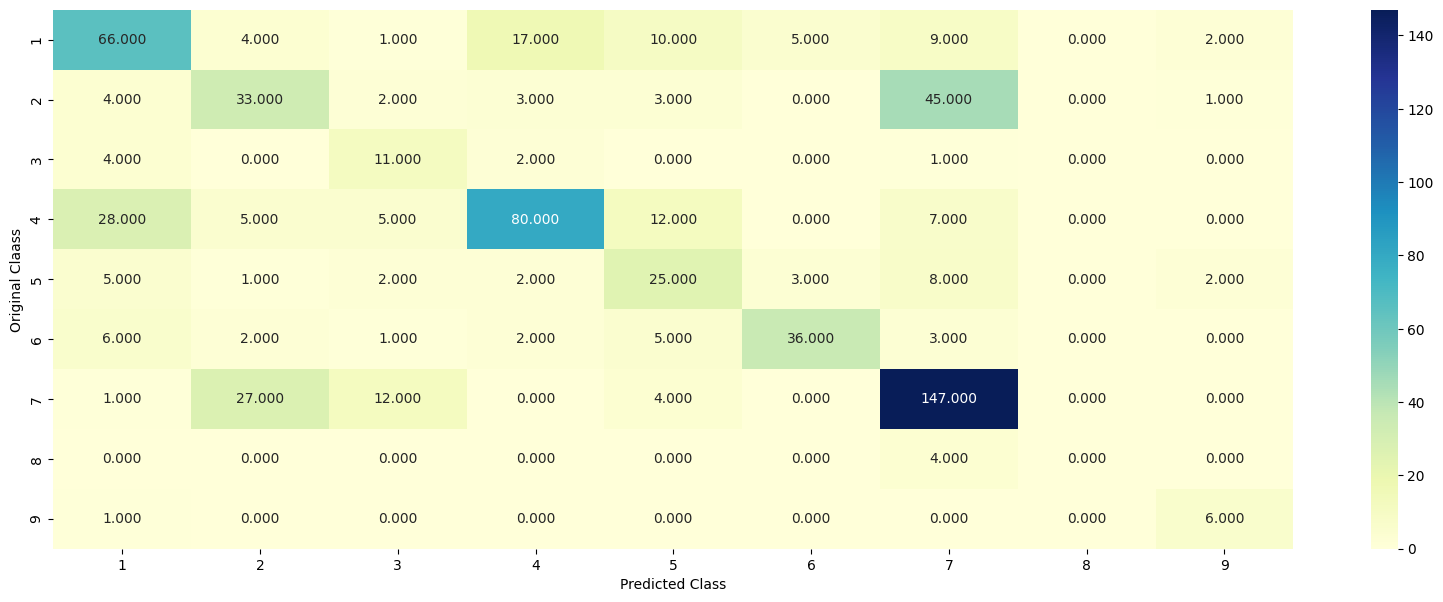

Precision Matrix (Column sum=1)


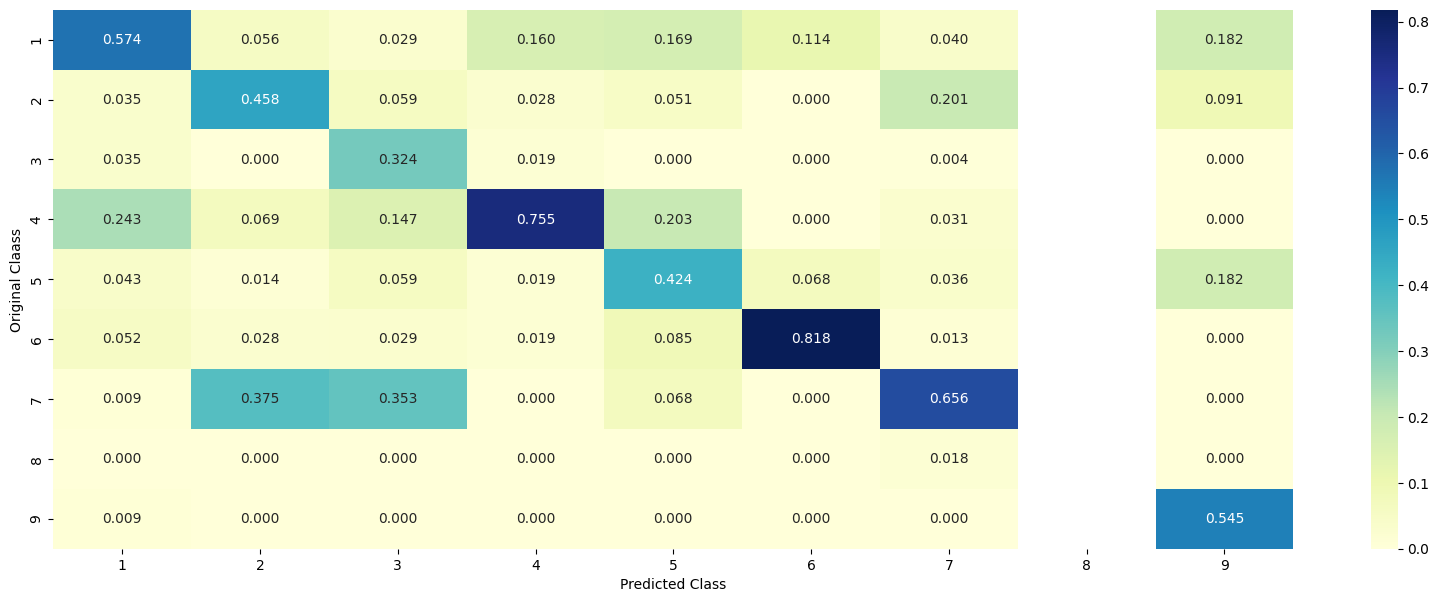

Recall Matrix (Row sum=1)


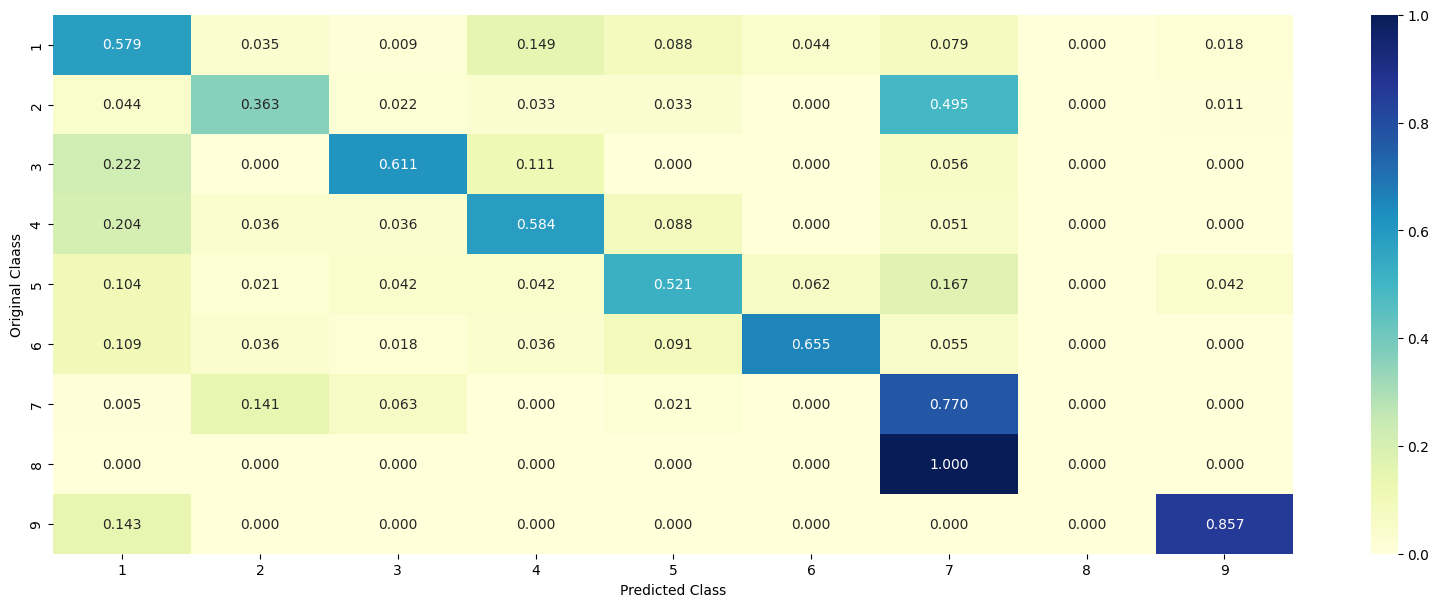

In [ ]:
#Hyperparameter tuning
alpha=[10**i for i in range(-5,4)]
cv_log_error=[]
for i in alpha:
  clf=MultinomialNB(alpha=i)
  clf.fit(x_train_ohe,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(x_train_ohe,y_train)
  predict_probs=sig_clf.predict_proba(x_cv_ohe)
  error=log_loss(y_cv,predict_probs,labels=clf.classes_,eps=1e-15)
  cv_log_error.append(error)
  print("For alpha=",i,"Log loss is ",error)

fig,ax=plt.subplots()
ax.plot(np.log10(alpha),cv_log_error,c='g')
for i,txt in enumerate(np.round(cv_log_error,3)):
  ax.annotate((alpha[i],str(txt)),(np.log10(alpha[i]),cv_log_error[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross validation error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha=alpha[np.argmin(cv_log_error)]
#print(best_alpha)
clf=MultinomialNB(alpha=best_alpha)
clf.fit(x_train_ohe,y_train)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(x_train_ohe,y_train)

predict_y=sig_clf.predict_proba(x_train_ohe)
print("For best alpha=",best_alpha,"Train Log loss is ",log_loss(y_train,predict_y,labels=clf.classes_,eps=1e-15))
predict_y=sig_clf.predict_proba(x_cv_ohe)
print("For best alpha=",best_alpha,"Cross Validation Log loss is ",log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
predict_y=sig_clf.predict_proba(x_test_ohe)
print("For best alpha=",best_alpha,"Test Log loss is ",log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))

predicted_y=sig_clf.predict(x_test_ohe)
print("No of misclassified points",np.count_nonzero((y_test-predicted_y))/len(y_test))
plot_confusion_matrix(y_test,predicted_y)

### Feature importance for correctly classified points

In [ ]:
test_point_index=10
no_feature=100
predicted_cls=sig_clf.predict(x_test_ohe[test_point_index])
print("Predicted class:",predicted_cls[0])
print("Actual class:",y_test[test_point_index])
indices=np.argsort(-1*clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
get_impfeature_names(indices[0],x_test['Text'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index],x_test['Variation'].iloc[test_point_index],no_feature)

Predicted class: 7
Actual class: 7
Out of the top  100  features  0 are present in query point


## **KNN**

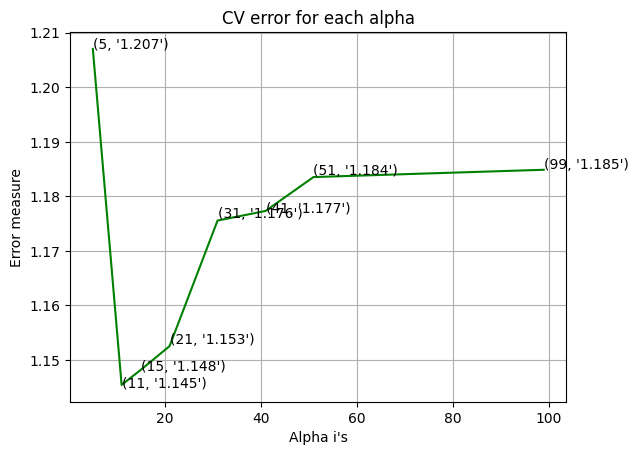

For best alpha= 11 Train Log loss is  0.4323979905617689
For best alpha= 11 Cross Validation Log loss is  1.1454389889449141
For best alpha= 11 Test Log loss is  1.0984847399634254
log_loss:  1.0984847399634254
No of mis classified points: 0.362406015037594
Confusion Matrix


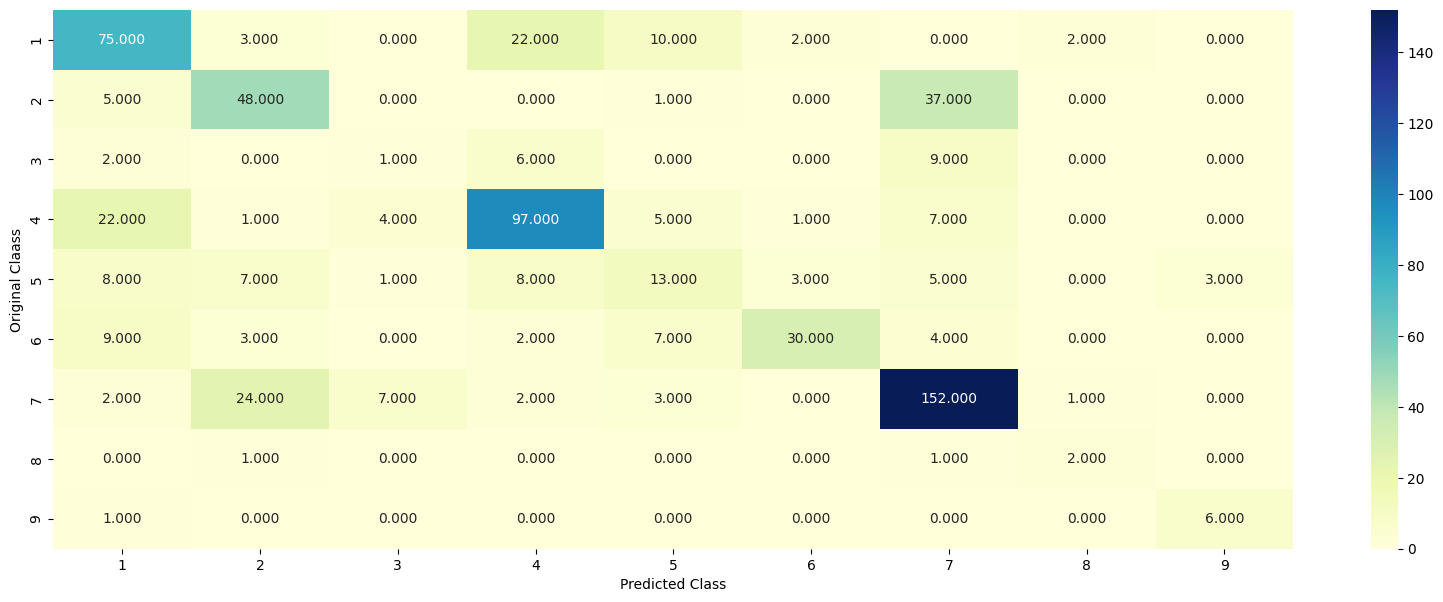

Precision Matrix (Column sum=1)


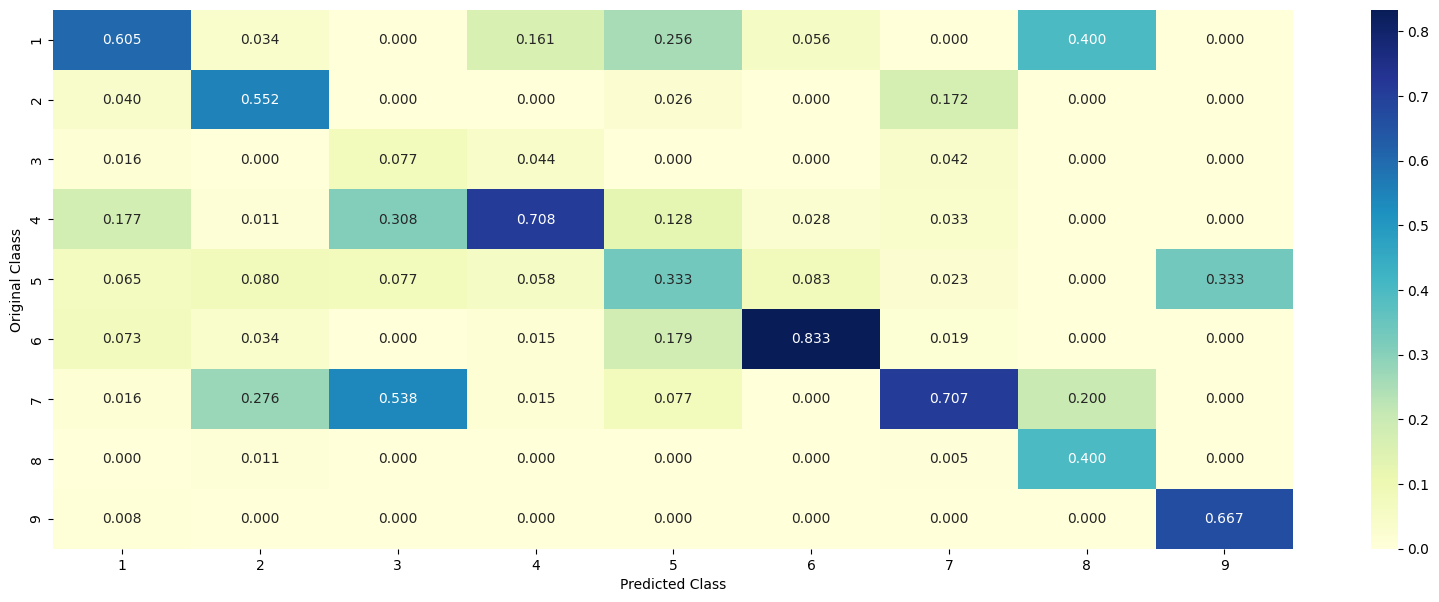

Recall Matrix (Row sum=1)


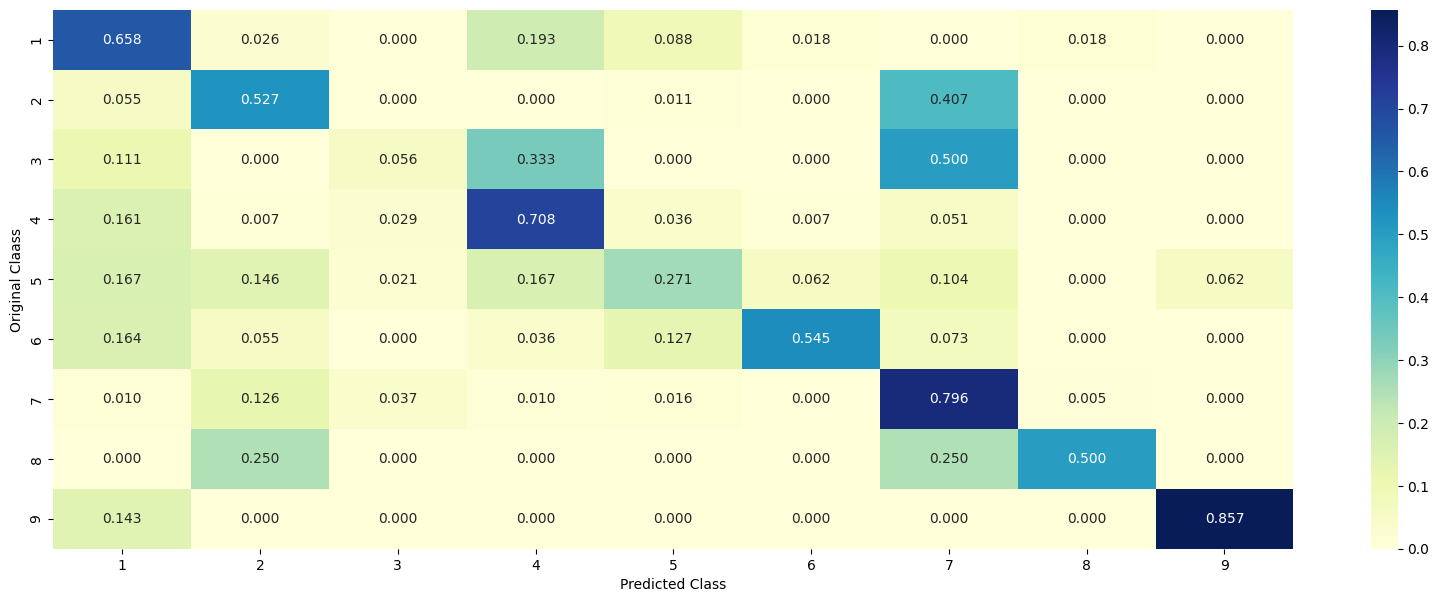

In [ ]:
#in KNN we use response coding than one hot encoding as its high dim, knn doesnt wrk well
alpha=[5,11,15,21,31,41,51,99]
cv_log_error=[]
for i in alpha:
  clf=KNeighborsClassifier(n_neighbors=i)
  clf.fit(x_train_rc,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(x_train_rc,y_train)
  sig_clf_probs=sig_clf.predict_proba(x_cv_rc)
  cv_log_error.append(log_loss(y_cv,sig_clf_probs,labels=clf.classes_,eps=1e-15))

fig,ax=plt.subplots()
ax.plot(alpha,cv_log_error,c='g')
for i,txt in enumerate(np.round(cv_log_error,3)):
  ax.annotate((alpha[i],str(txt)),(alpha[i],np.round(cv_log_error[i],3)))
plt.grid()
plt.title("CV error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha=alpha[np.argmin(cv_log_error)]
clf=KNeighborsClassifier(n_neighbors=best_alpha)
clf.fit(x_train_rc,y_train)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(x_train_rc,y_train)

predict_y=sig_clf.predict_proba(x_train_rc)
print("For best alpha=",best_alpha,"Train Log loss is ",log_loss(y_train,predict_y,labels=clf.classes_,eps=1e-15))
predict_y=sig_clf.predict_proba(x_cv_rc)
print("For best alpha=",best_alpha,"Cross Validation Log loss is ",log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
predict_y=sig_clf.predict_proba(x_test_rc)
print("For best alpha=",best_alpha,"Test Log loss is ",log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))

clf=KNeighborsClassifier(n_neighbors=best_alpha)
predict_plot_confusion_matrix(x_train_rc,y_train,x_test_rc,y_test,clf)

## **Logistic Regression with class balance**

For values of alpha:  1e-06  Log loss is:  1.350528634731672
For values of alpha:  1e-05  Log loss is:  1.3310527501140652
For values of alpha:  0.0001  Log loss is:  1.1584486800251101
For values of alpha:  0.001  Log loss is:  1.1114907197534853
For values of alpha:  0.01  Log loss is:  1.186933321837324
For values of alpha:  0.1  Log loss is:  1.4725863445657688
For values of alpha:  1  Log loss is:  1.7062703025891548
For values of alpha:  10  Log loss is:  1.736818734439481
For values of alpha:  100  Log loss is:  1.7401033894979918


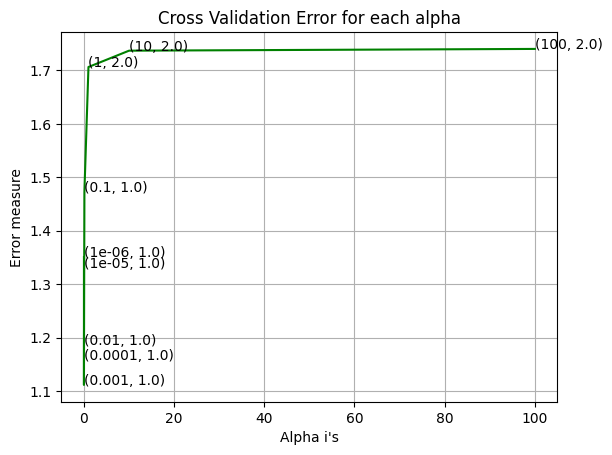

For values of best alpha  0.001  Train log loss is:  0.5297923223146218
For values of best alpha  0.001  Cross Validation log loss is:  1.1114907197534853
For values of best alpha  0.001  Test log loss is:  1.030288059057761
Confusion Matrix


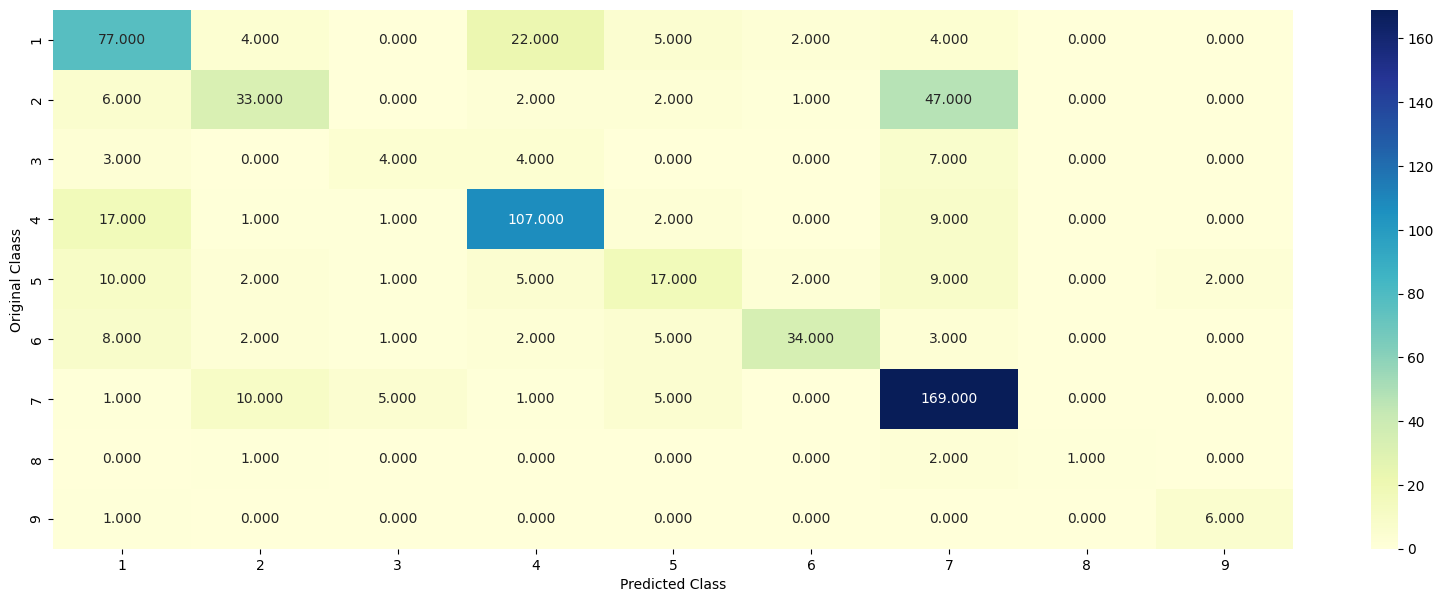

Precision Matrix (Column sum=1)


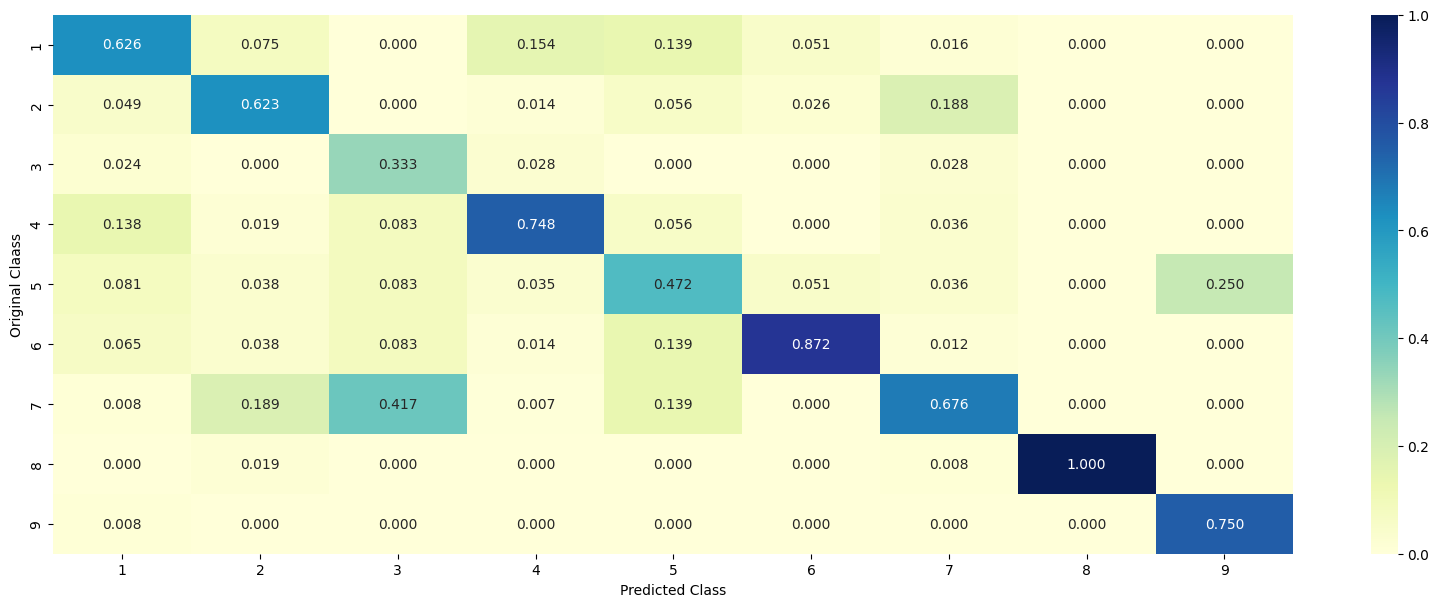

Recall Matrix (Row sum=1)


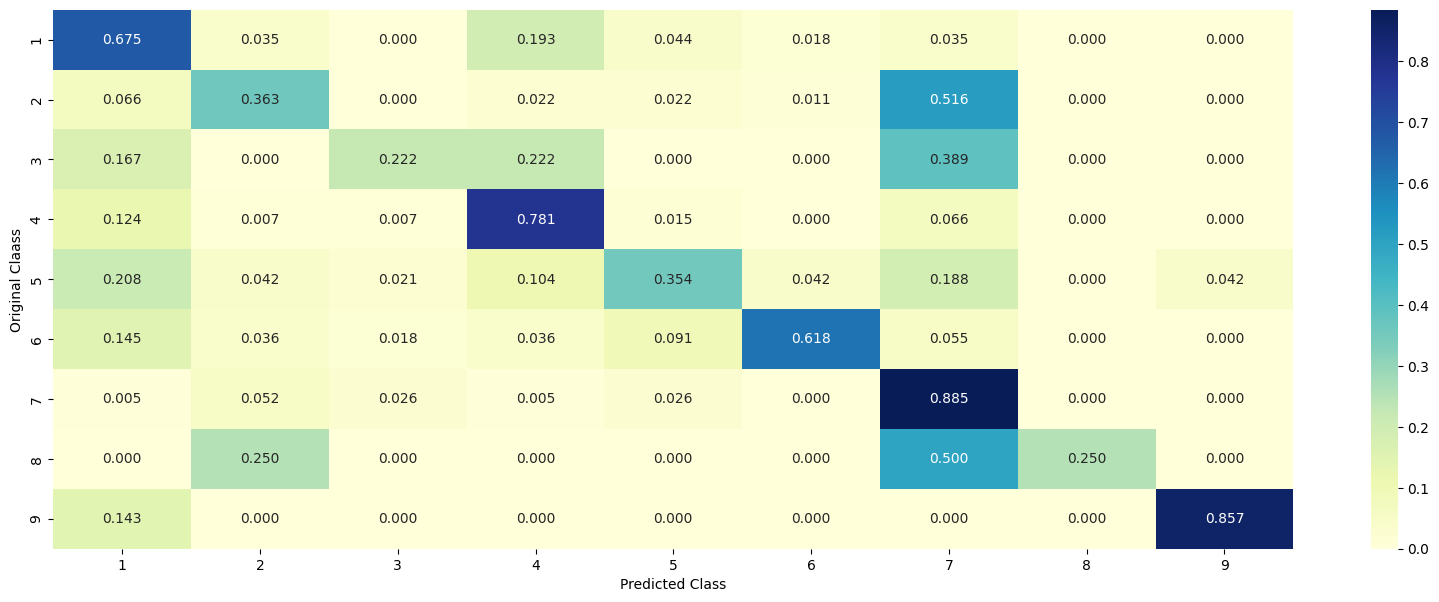

In [ ]:
#hyperparameter tuning
alpha=[10**i for i in range(-6,3)]
predict_y,best_alpha=predicting_y(alpha,'log',x_train_ohe,x_cv_ohe,x_test_ohe,y_train,y_cv,y_test,'balanced')
plot_confusion_matrix(y_test,predict_y)

### Feature Importance

In [ ]:
#Correctly classified points
clf=SGDClassifier(alpha=best_alpha,loss='log',class_weight='balanced',random_state=42,penalty='l2')
clf.fit(x_train_ohe,y_train)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(x_train_ohe,y_train)

test_point_index=2
no_feature=500
predicted_cls=sig_clf.predict(x_test_ohe[test_point_index])
print("Predicted class:",predicted_cls[0])
print("Actual class:",y_test[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
get_impfeature_names(indices[0],x_test['Text'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index].lower(),x_test['Variation'].iloc[test_point_index],no_feature)

Predicted class: 1
Actual class: 5
269 Text feature [ a1752p ] present in test data point True
341 Text feature [ data ] present in test data point True
368 Text feature [ 492 ] present in test data point True
441 Text feature [ basal ] present in test data point True
493 Text feature [ developing ] present in test data point True
Out of the top  500  features  5 are present in query point


## **Logistic Regression without class balance**

For values of alpha:  1e-06  Log loss is:  1.3331278397756976
For values of alpha:  1e-05  Log loss is:  1.3025157233792002
For values of alpha:  0.0001  Log loss is:  1.1803747488048875
For values of alpha:  0.001  Log loss is:  1.1247730284173754
For values of alpha:  0.01  Log loss is:  1.2393805263653939
For values of alpha:  0.1  Log loss is:  1.4372516988666564
For values of alpha:  1  Log loss is:  1.6411246716762615
For values of alpha:  10  Log loss is:  1.6789915520378658
For values of alpha:  100  Log loss is:  1.6828136885791465


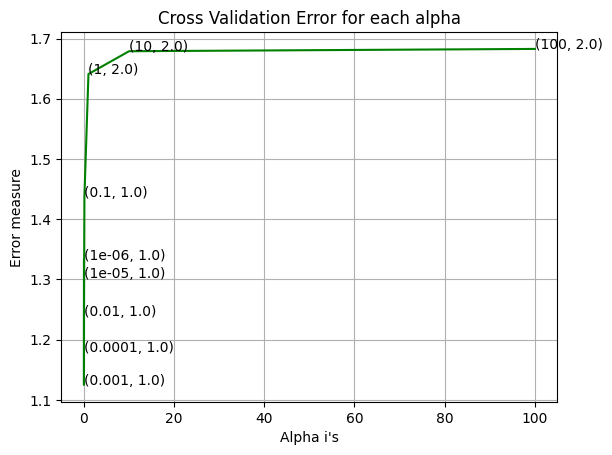

For values of best alpha  0.001  Train log loss is:  0.5341314191848462
For values of best alpha  0.001  Cross Validation log loss is:  1.1247730284173754
For values of best alpha  0.001  Test log loss is:  1.040696275693517
Confusion Matrix


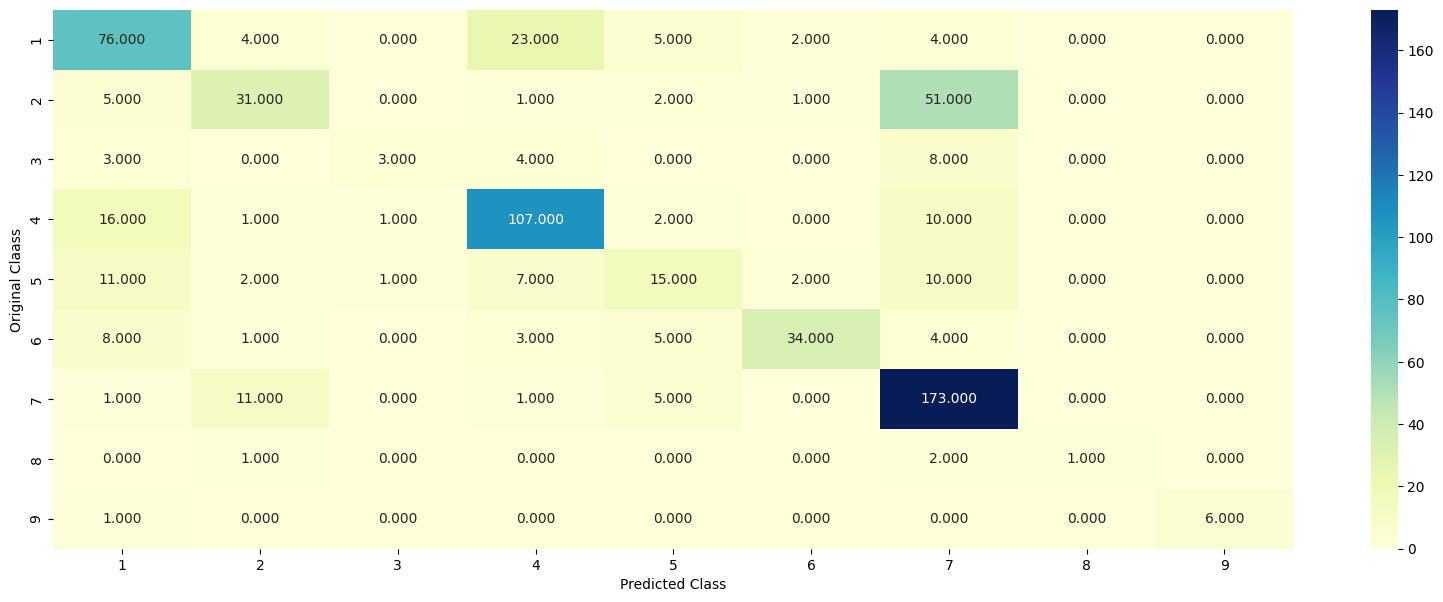

Precision Matrix (Column sum=1)


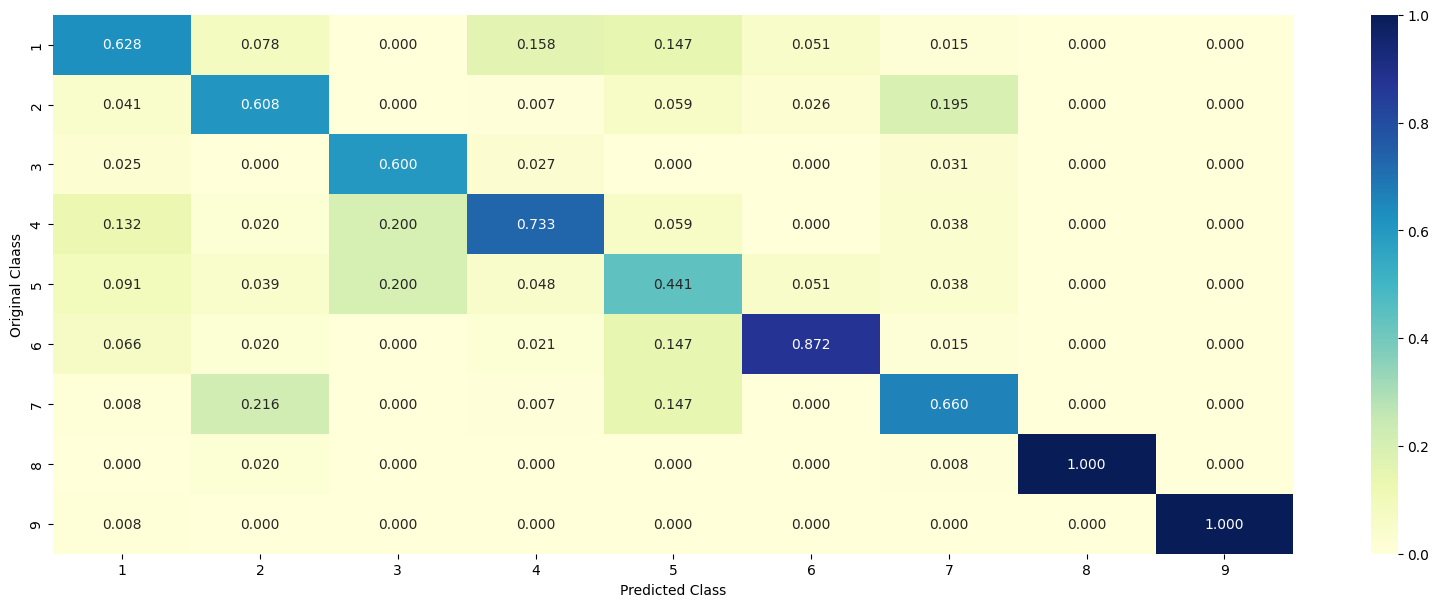

Recall Matrix (Row sum=1)


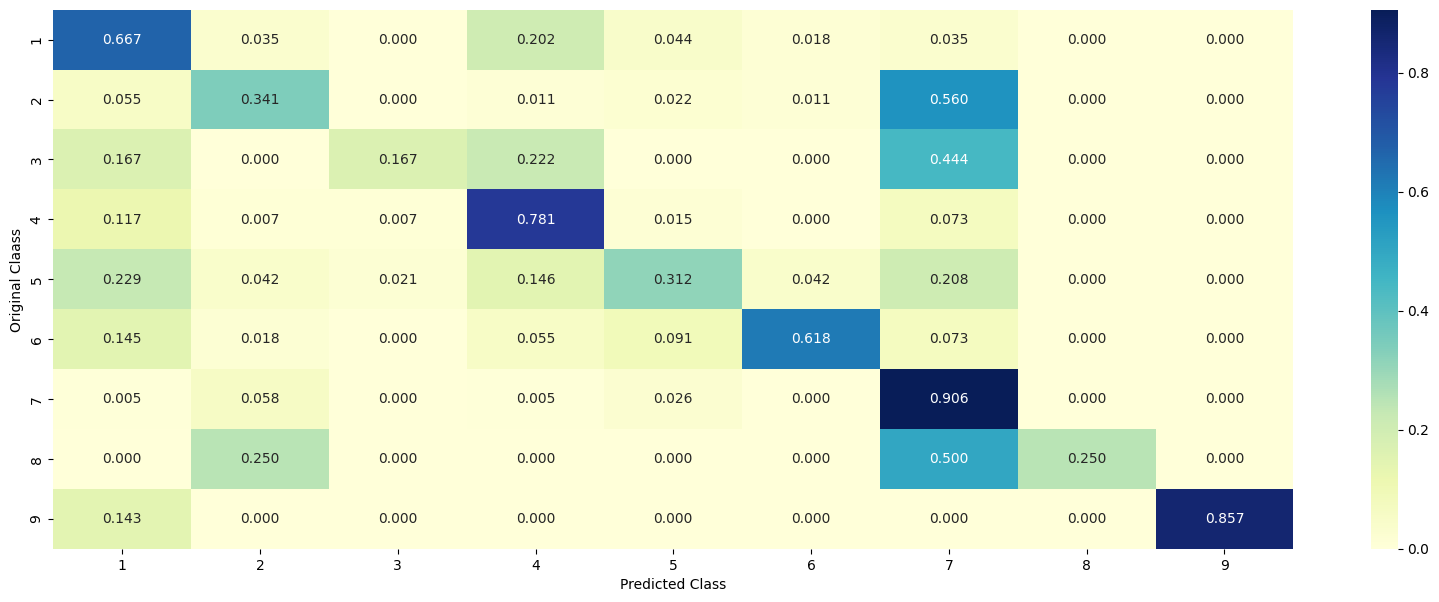

In [ ]:
#hyperparameter tuning
alpha=[10**i for i in range(-6,3)]
predict_y,best_alpha=predicting_y(alpha,'log',x_train_ohe,x_cv_ohe,x_test_ohe,y_train,y_cv,y_test,None)
plot_confusion_matrix(y_test,predict_y)

### Feature importance

In [ ]:
#Correctly classified points
clf=SGDClassifier(alpha=best_alpha,loss='log',class_weight=None,random_state=42,penalty='l2')
clf.fit(x_train_ohe,y_train)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(x_train_ohe,y_train)

test_point_index=5
no_feature=100
predicted_cls=sig_clf.predict(x_test_ohe[test_point_index])
print("Predicted class:",predicted_cls[0])
print("Actual class:",y_test[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
get_impfeature_names(indices[0],x_test['Text'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index].lower(),x_test['Variation'].iloc[test_point_index],no_feature)

Predicted class: 7
Actual class: 3
9 Gene feature [ pdgfra ] present in test data point True
Out of the top  100  features  1 are present in query point


## **Linear SVM**

For values of alpha:  1e-05  Log loss is:  1.3284051510295405
For values of alpha:  0.0001  Log loss is:  1.251961437738475
For values of alpha:  0.001  Log loss is:  1.1435273124588423
For values of alpha:  0.01  Log loss is:  1.1425614306879799
For values of alpha:  0.1  Log loss is:  1.3715028798410502
For values of alpha:  1  Log loss is:  1.6669739973724667
For values of alpha:  10  Log loss is:  1.6830845499428306
For values of alpha:  100  Log loss is:  1.6830971333693074


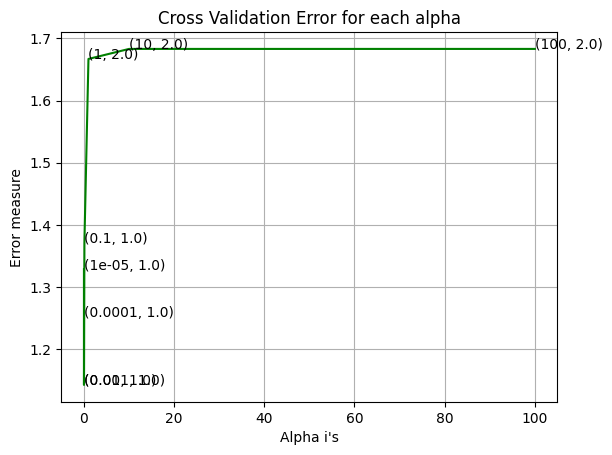

For values of best alpha  0.01  Train log loss is:  0.7253014383460162
For values of best alpha  0.01  Cross Validation log loss is:  1.1425614306879799
For values of best alpha  0.01  Test log loss is:  1.1046242652068001
Confusion Matrix


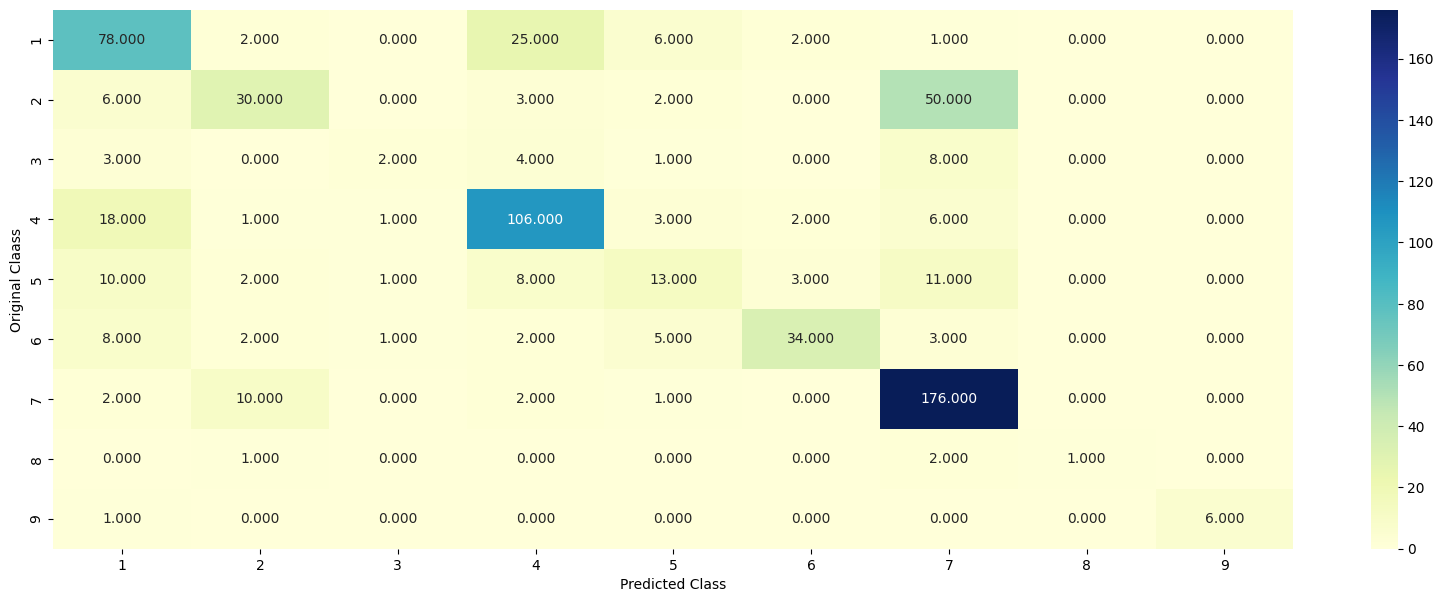

Precision Matrix (Column sum=1)


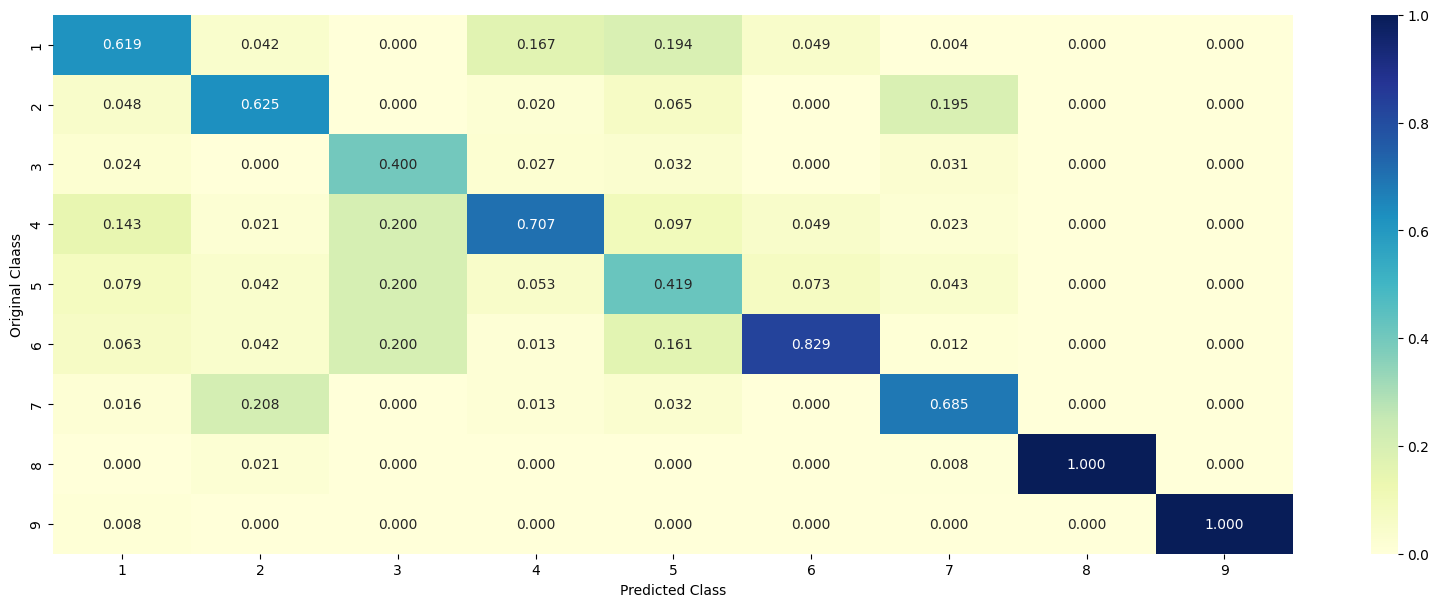

Recall Matrix (Row sum=1)


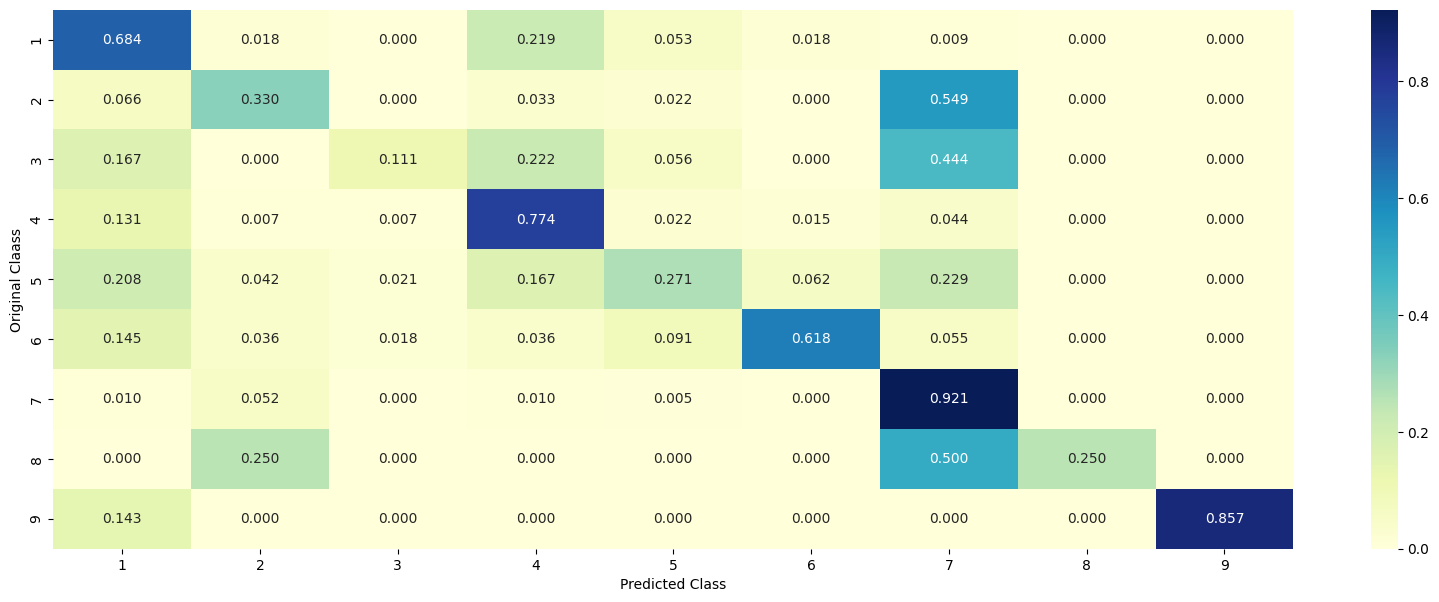

In [ ]:
#hyperparameter tuning
alpha=[10**i for i in range(-5,3)]
predict_y,best_alpha=predicting_y(alpha,'hinge',x_train_ohe,x_cv_ohe,x_test_ohe,y_train,y_cv,y_test,None)
plot_confusion_matrix(y_test,predict_y)

### Feature importance

In [ ]:
#Correctly classified points
clf=SGDClassifier(alpha=best_alpha,loss='hinge',random_state=42,penalty='l2')
clf.fit(x_train_ohe,y_train)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(x_train_ohe,y_train)

test_point_index=2
no_feature=100
predicted_cls=sig_clf.predict(x_test_ohe[test_point_index])
print("Predicted class:",predicted_cls[0])
print("Actual class:",y_test[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
get_impfeature_names(indices[0],x_test['Text'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index].lower(),x_test['Variation'].iloc[test_point_index],no_feature)

Predicted class: 4
Actual class: 5
1 Gene feature [ brca1 ] present in test data point True
Out of the top  100  features  1 are present in query point


## **Random Forest**

In [ ]:
def random_forest(alpha,max_depth,train,cv,test,ytrain,ycv,ytest):
  cv_log_error=[]
  for i in alpha:
    for j in max_depth:
      clf=RandomForestClassifier(n_estimators=i,criterion='gini',max_depth=j,n_jobs=-1)
      clf.fit(train,ytrain)
      sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
      sig_clf.fit(train,ytrain)
      sig_clf_probs=sig_clf.predict_proba(cv)
      error=log_loss(ycv,sig_clf_probs,labels=clf.classes_,eps=1e-15)
      cv_log_error.append(error)
      print("For n-estimators:",i,"and max depth:",j,"Log loss is",error)

  best_alpha = np.argmin(cv_log_error)
  best_n_estimator=alpha[int(best_alpha/len(max_depth))]
  best_max_depth=max_depth[best_alpha%len(max_depth)]
  print("\nBest max depth is:",best_max_depth,"\nBest alpha is:",best_n_estimator)

  clf=RandomForestClassifier(n_estimators=best_n_estimator,max_depth=best_max_depth,criterion='gini',n_jobs=-1)
  clf.fit(train,ytrain)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train,ytrain)
  predict_y=sig_clf.predict_proba(train)
  print("\nTrain log loss is:",log_loss(ytrain,predict_y,labels=clf.classes_,eps=1e-15))
  predict_y=sig_clf.predict_proba(cv)
  print("Cross validation log loss is:",log_loss(ycv,predict_y,labels=clf.classes_,eps=1e-15))
  predict_y=sig_clf.predict_proba(test)
  print("Test log loss is:",log_loss(ytest,predict_y,labels=clf.classes_,eps=1e-15),"\n")

  predicted_y=sig_clf.predict(test)
  plot_confusion_matrix(ytest,predicted_y)

  #Feature importance
  test_point_index=2
  no_feature=500
  indices=np.argsort(-clf.feature_importances_)
  print("*"*10,"FEATURE IMPORTANCE","*"*10)
  get_impfeature_names(indices[:no_feature],x_test['Text'].iloc[test_point_index],x_test['Gene'].iloc[test_point_index].lower(),x_test['Variation'].iloc[test_point_index],no_feature)

For n-estimators: 100 and max depth: 1 Log loss is 1.4625915842775723
For n-estimators: 100 and max depth: 5 Log loss is 1.2396319203643955
For n-estimators: 100 and max depth: 10 Log loss is 1.1904283937875362
For n-estimators: 500 and max depth: 1 Log loss is 1.4516162863029844
For n-estimators: 500 and max depth: 5 Log loss is 1.211258543143051
For n-estimators: 500 and max depth: 10 Log loss is 1.1671898189556358
For n-estimators: 1000 and max depth: 1 Log loss is 1.4487853784328595
For n-estimators: 1000 and max depth: 5 Log loss is 1.2102655835317433
For n-estimators: 1000 and max depth: 10 Log loss is 1.1657288473474445
For n-estimators: 2000 and max depth: 1 Log loss is 1.4534803311160043
For n-estimators: 2000 and max depth: 5 Log loss is 1.2124605448663515
For n-estimators: 2000 and max depth: 10 Log loss is 1.1621057756141928

Best max depth is: 10 
Best alpha is: 2000

Train log loss is: 0.6671612651248321
Cross validation log loss is: 1.1618550416329043
Test log loss is: 1

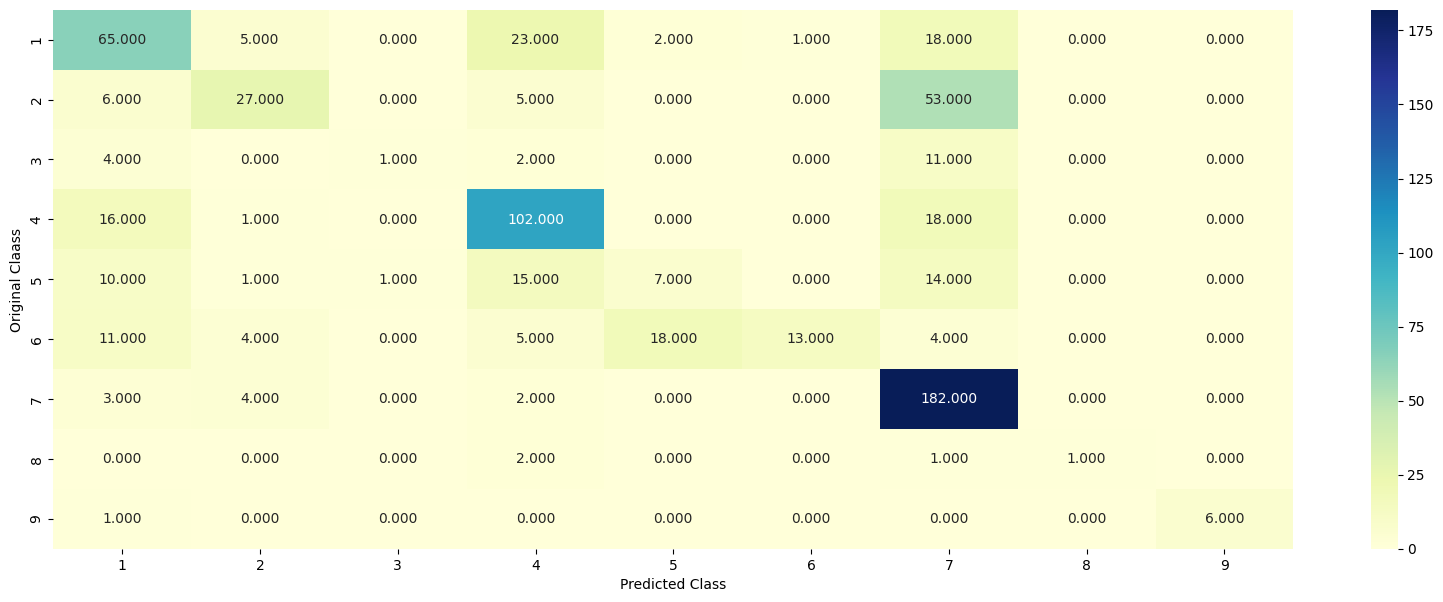

Precision Matrix (Column sum=1)


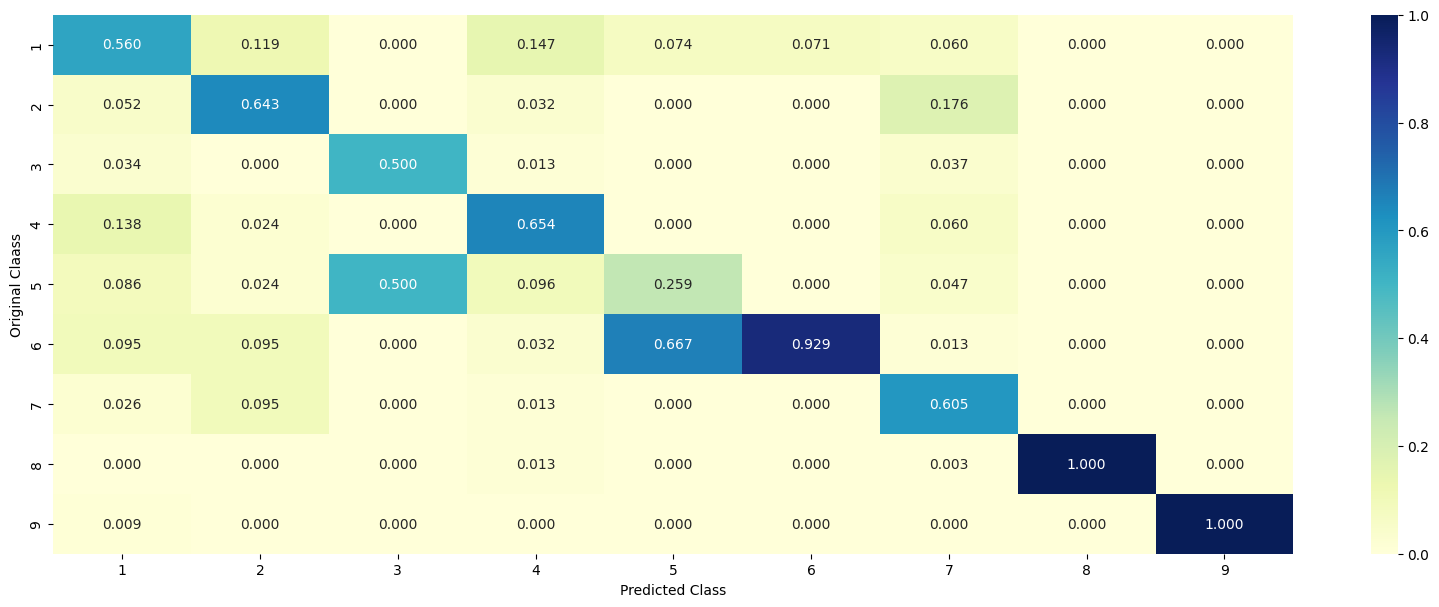

Recall Matrix (Row sum=1)


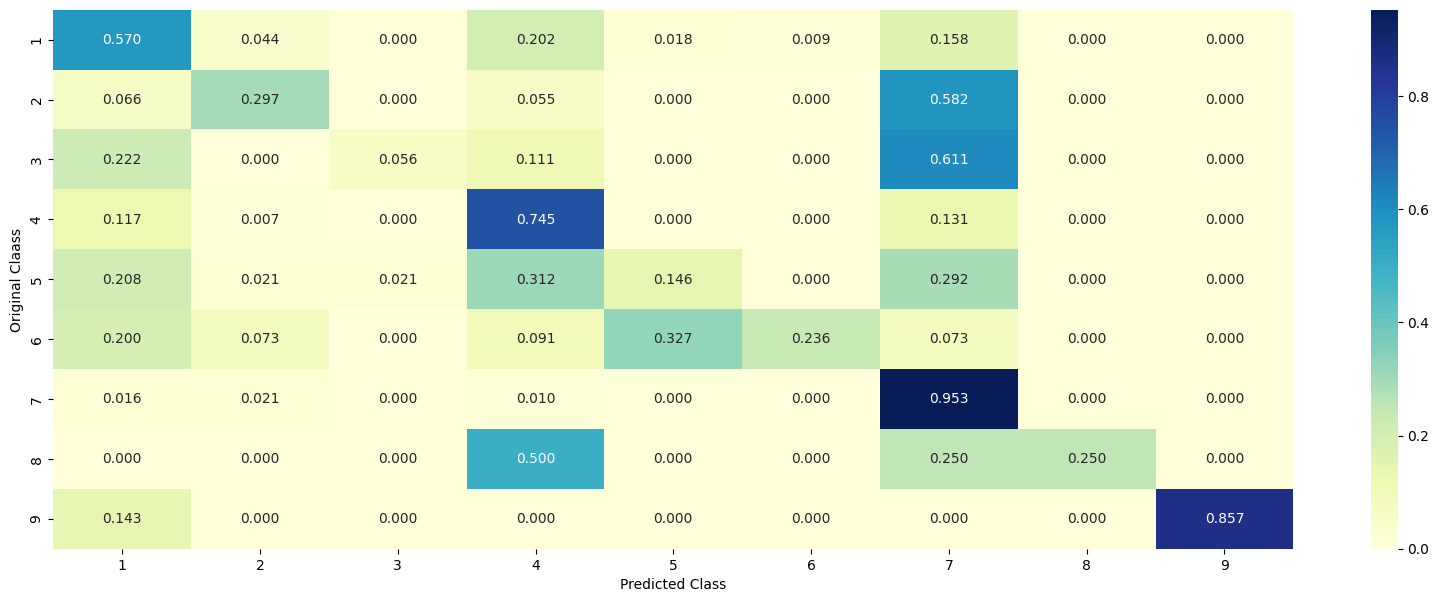

********** FEATURE IMPORTANCE **********
18 Text feature [ effects ] present in test data point True
27 Text feature [ c1697r ] present in test data point True
36 Text feature [ allowed ] present in test data point True
140 Gene feature [ brca1 ] present in test data point True
203 Text feature [ accordance ] present in test data point True
384 Text feature [ 350 ] present in test data point True
Out of the top  500  features  6 are present in query point


In [ ]:
alpha=[100,500,1000,2000]
max_depth=[1,5,10]
random_forest(alpha,max_depth,x_train_ohe,x_cv_ohe,x_test_ohe,y_train,y_cv,y_test)

For n-estimators: 100 and max depth: 3 Log loss is 1.529411766106504
For n-estimators: 100 and max depth: 5 Log loss is 1.3837640968298808
For n-estimators: 100 and max depth: 10 Log loss is 1.6354660232739784
For n-estimators: 500 and max depth: 3 Log loss is 1.5443849070401674
For n-estimators: 500 and max depth: 5 Log loss is 1.382440791404571
For n-estimators: 500 and max depth: 10 Log loss is 1.6797595421433067
For n-estimators: 1000 and max depth: 3 Log loss is 1.554031928052659
For n-estimators: 1000 and max depth: 5 Log loss is 1.3803494134925116
For n-estimators: 1000 and max depth: 10 Log loss is 1.6746746421490202
For n-estimators: 2000 and max depth: 3 Log loss is 1.5240792423713736
For n-estimators: 2000 and max depth: 5 Log loss is 1.3976678133839793
For n-estimators: 2000 and max depth: 10 Log loss is 1.690998607389119

Best max depth is: 5 
Best alpha is: 1000

Train log loss is: 0.05828111040156028
Cross validation log loss is: 1.398814190202243
Test log loss is: 1.352

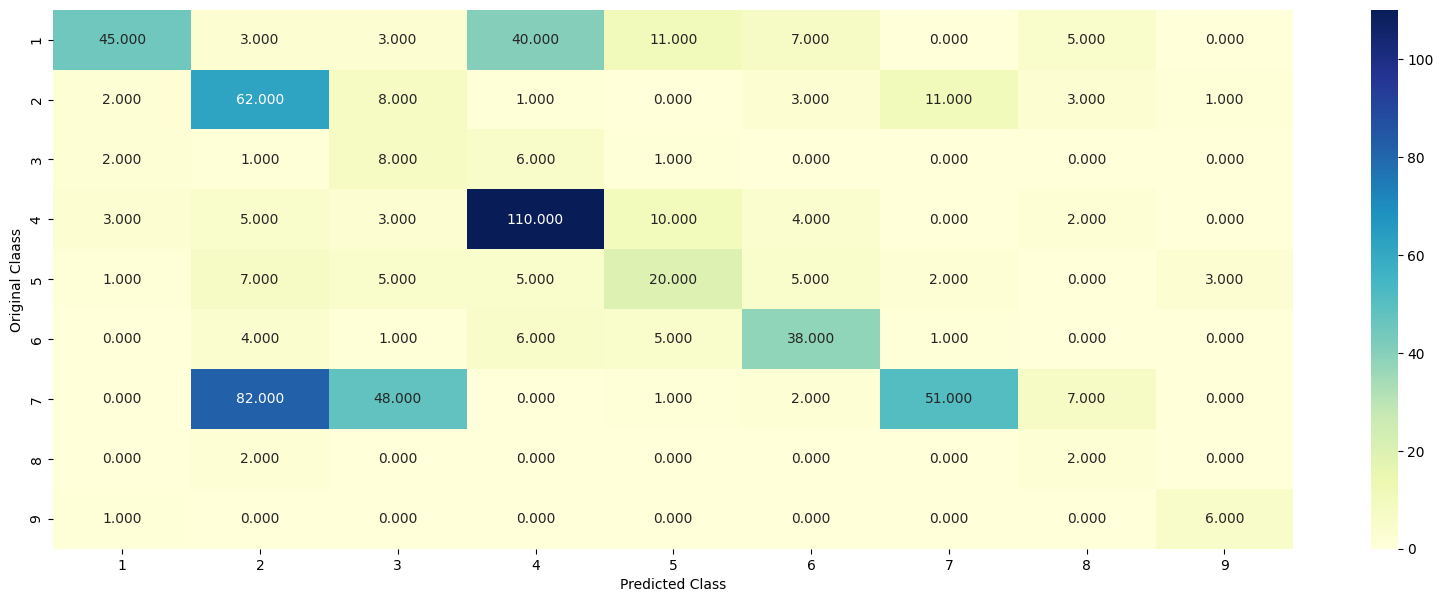

Precision Matrix (Column sum=1)


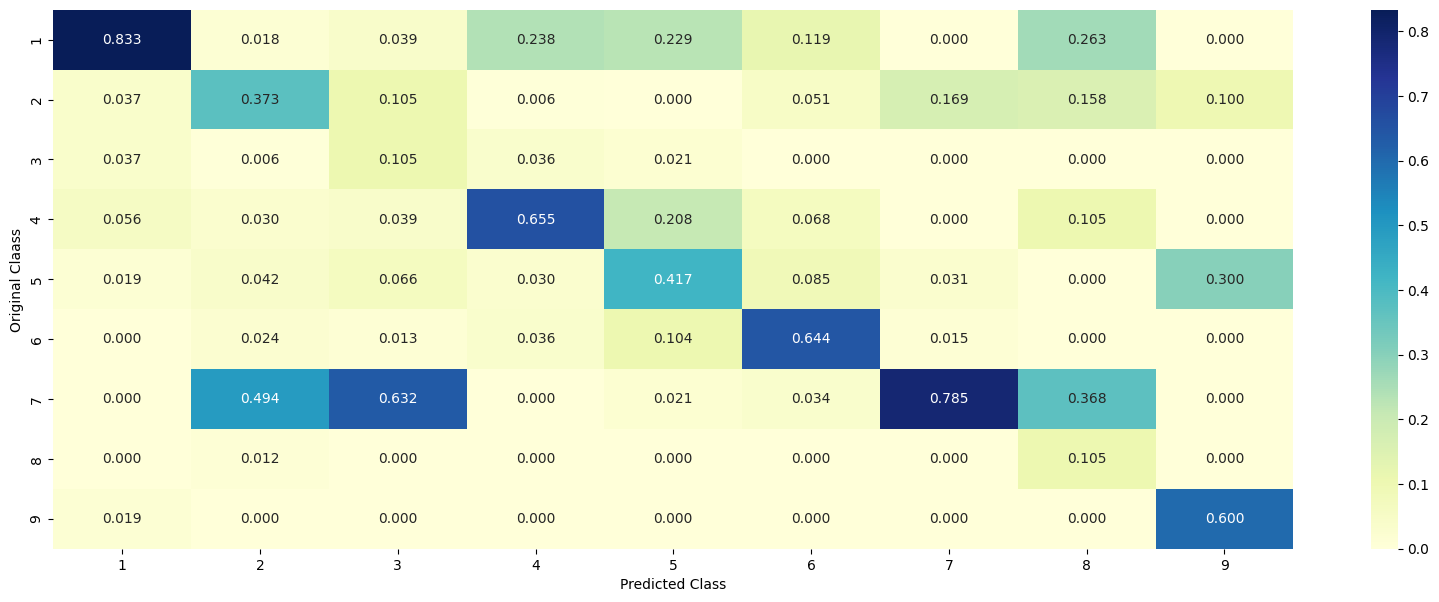

Recall Matrix (Row sum=1)


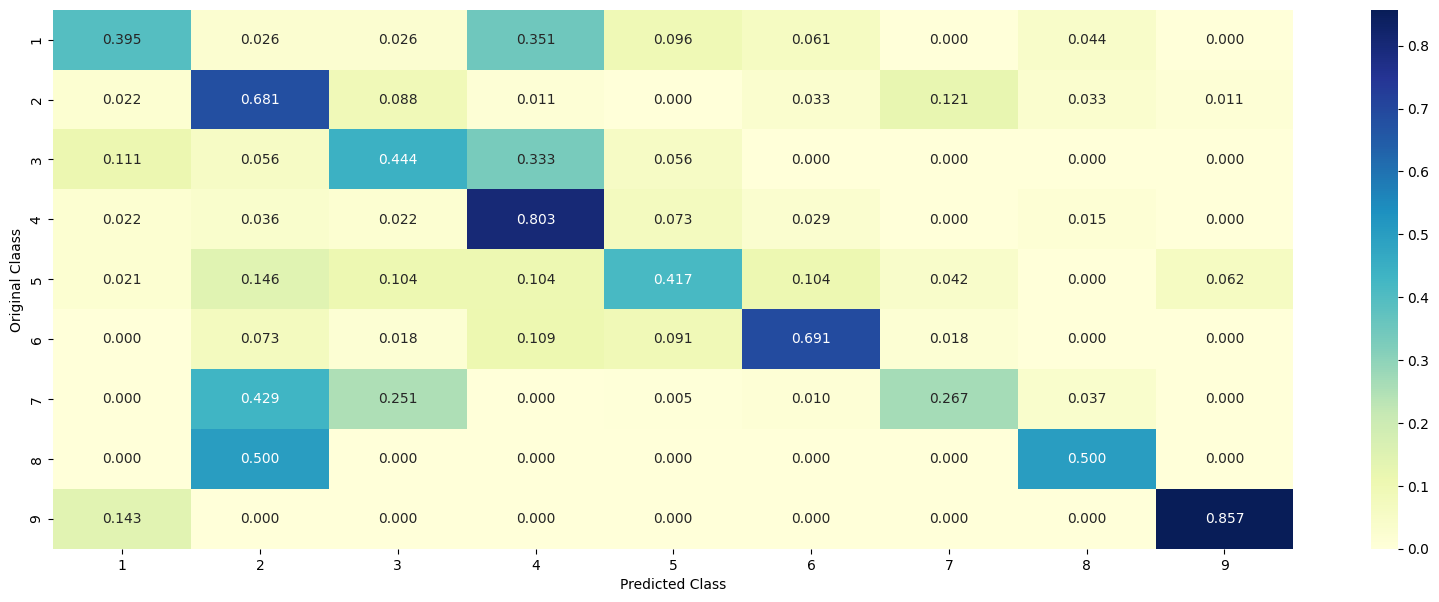

********** FEATURE IMPORTANCE **********
7 Gene feature [ brca1 ] present in test data point True
Out of the top  500  features  1 are present in query point


In [ ]:
#Random forest with response coding
alpha=[100,500,1000,2000]
max_depth=[3,5,10]
random_forest(alpha,max_depth,x_train_rc,x_cv_rc,x_test_rc,y_train,y_cv,y_test)

## **Stack the Models**

Logistic Regression log loss is 1.1114907197534853
Linear SVM log loss is 1.1482773887354718
Naive Baye's log loss is 1.3032855263748762
Stacking Classifier log loss for alpha= 0.0001 is 1.813936459418986
Stacking Classifier log loss for alpha= 0.001 is 1.6895099605075667
Stacking Classifier log loss for alpha= 0.01 is 1.2753604576490178
Stacking Classifier log loss for alpha= 0.1 is 1.1962510192121893
Stacking Classifier log loss for alpha= 1 is 1.4486500113475416
Stacking Classifier log loss for alpha= 10 is 1.825199899541283
Train log loss is 0.28578335316326897
Cross Validation log loss is 1.4703482029288244
Test log loss is 1.2944589119385688
Confusion Matrix


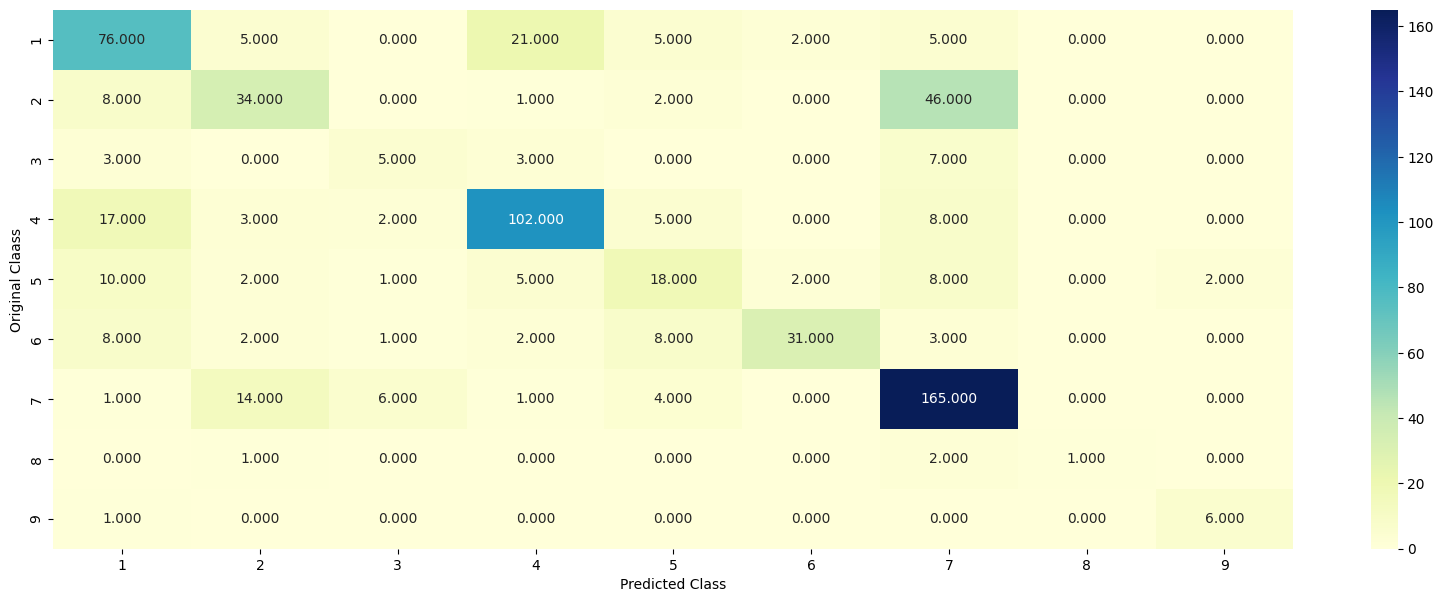

Precision Matrix (Column sum=1)


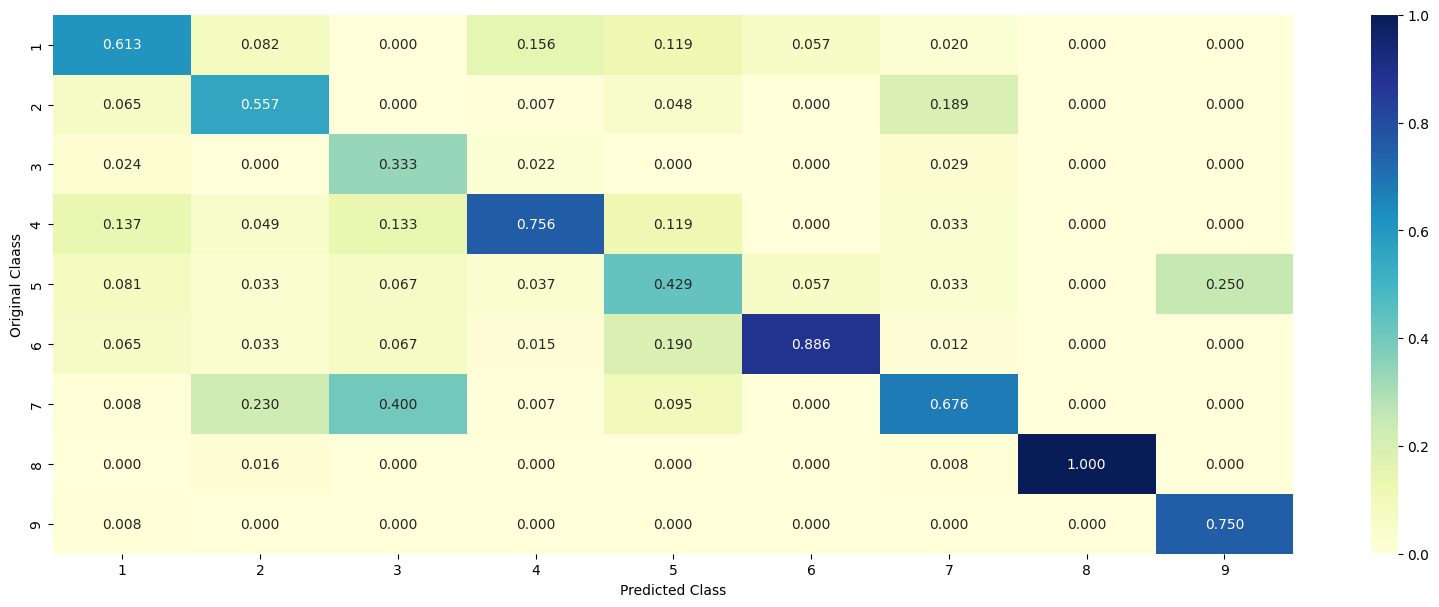

Recall Matrix (Row sum=1)


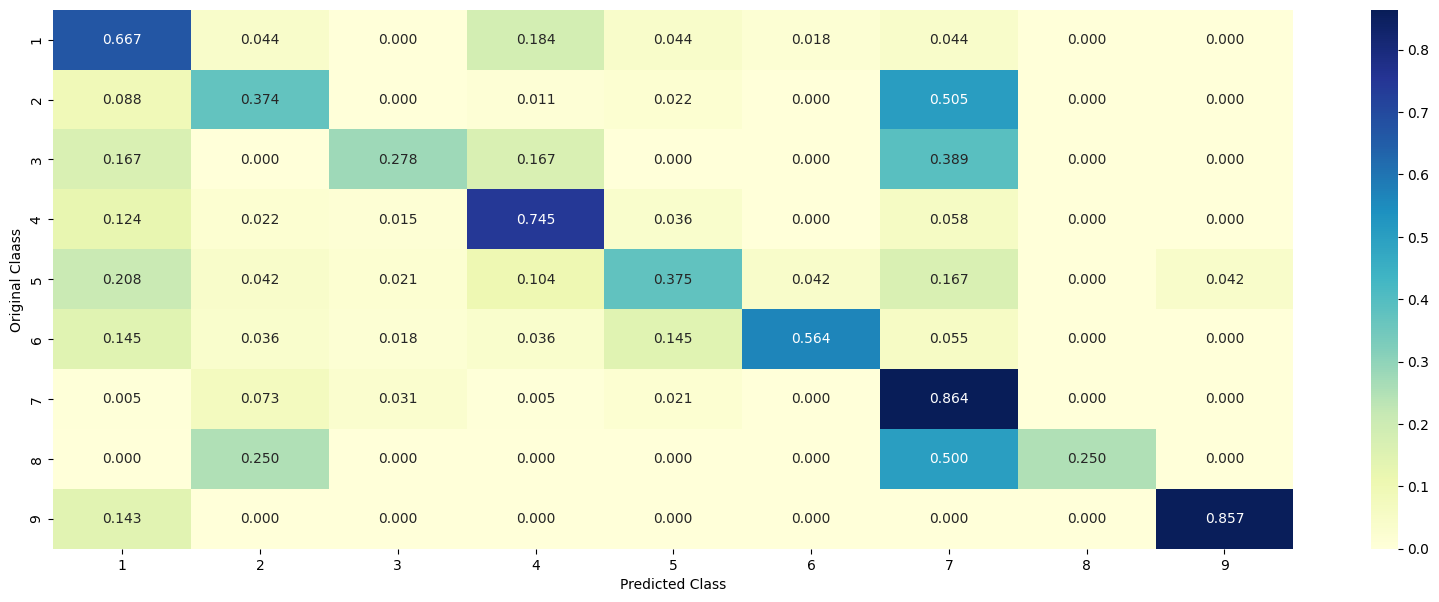

In [ ]:
clf1=SGDClassifier(alpha=0.001,penalty='l2',loss='log',class_weight='balanced',random_state=42)
clf1.fit(x_train_ohe,y_train)
sig_clf1=CalibratedClassifierCV(clf1,method='sigmoid')
sig_clf1.fit(x_train_ohe,y_train)
clf2=SGDClassifier(alpha=0.01,penalty='l2',loss='hinge',class_weight='balanced',random_state=42)
clf2.fit(x_train_ohe,y_train)
sig_clf2=CalibratedClassifierCV(clf2,method='sigmoid')
sig_clf2.fit(x_train_ohe,y_train)
clf3=MultinomialNB(alpha=0.01)
clf3.fit(x_train_ohe,y_train)
sig_clf3=CalibratedClassifierCV(clf3,method='sigmoid')
sig_clf3.fit(x_train_ohe,y_train)

print("Logistic Regression log loss is",log_loss(y_cv,sig_clf1.predict_proba(x_cv_ohe)))
print("Linear SVM log loss is",log_loss(y_cv,sig_clf2.predict_proba(x_cv_ohe)))
print("Naive Baye's log loss is",log_loss(y_cv,sig_clf3.predict_proba(x_cv_ohe)))

alpha=[0.0001,0.001,0.01,0.1,1,10]
best_alpha=999
for i in alpha:
  lr=LogisticRegression(C=i)
  sclf=StackingClassifier(classifiers=[sig_clf1,sig_clf2,sig_clf3],meta_classifier=lr,use_probas=True)
  sclf.fit(x_train_ohe,y_train)
  print("Stacking Classifier log loss for alpha=",i,"is",log_loss(y_cv,sclf.predict_proba(x_cv_ohe)))
  log_error=log_loss(y_cv,sclf.predict_proba(x_cv_ohe))
  if best_alpha>log_error:
    best_alpha=log_error

#using best_alpha
lr=LogisticRegression(C=best_alpha)
sclf=StackingClassifier(classifiers=[sig_clf1,sig_clf2,sig_clf3],meta_classifier=lr,use_probas=True)
sclf.fit(x_train_ohe,y_train)
log_error=log_loss(y_train,sclf.predict_proba(x_train_ohe))
print("Train log loss is",log_error)
log_error=log_loss(y_cv,sclf.predict_proba(x_cv_ohe))
print("Cross Validation log loss is",log_error)
log_error=log_loss(y_test,sclf.predict_proba(x_test_ohe))
print("Test log loss is",log_error)
plot_confusion_matrix(y_test,sclf.predict(x_test_ohe))

## **Maximum Voting Classifier**

Train log loss is 0.6829479494994484
Cross Validation log loss is 1.0944732978578402
Test log loss is 1.065379018564127
No of misclassified points 0.362406015037594
Confusion Matrix


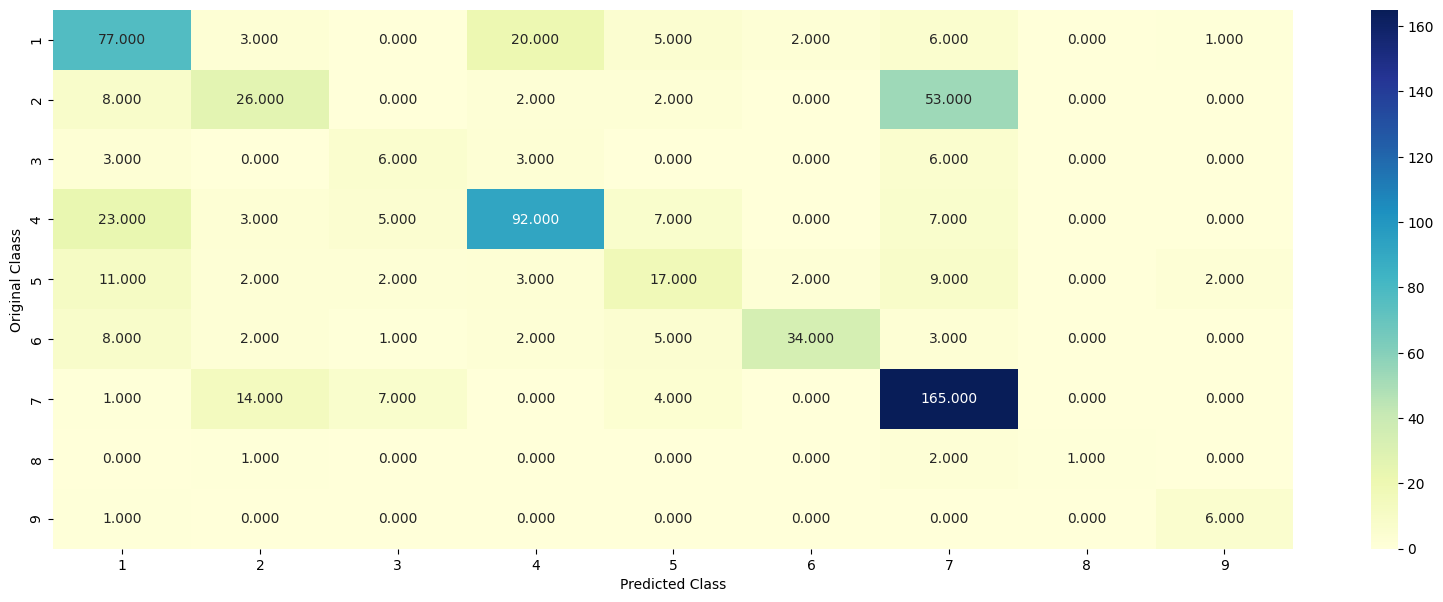

Precision Matrix (Column sum=1)


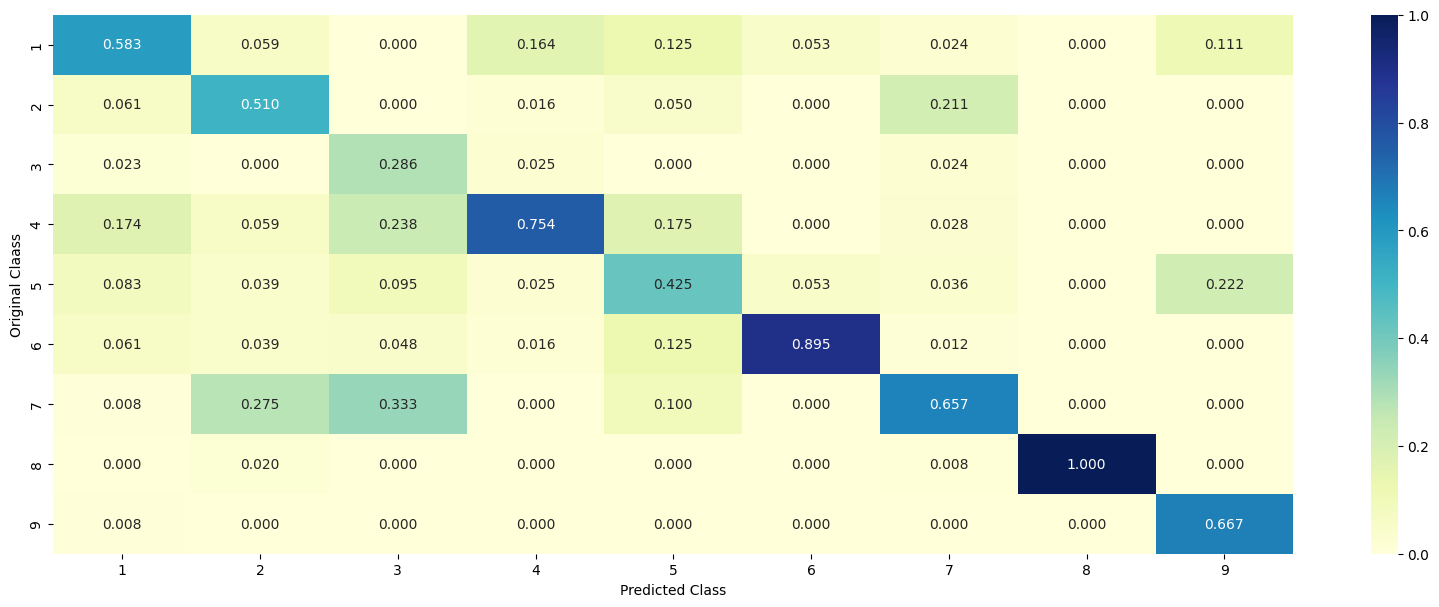

Recall Matrix (Row sum=1)


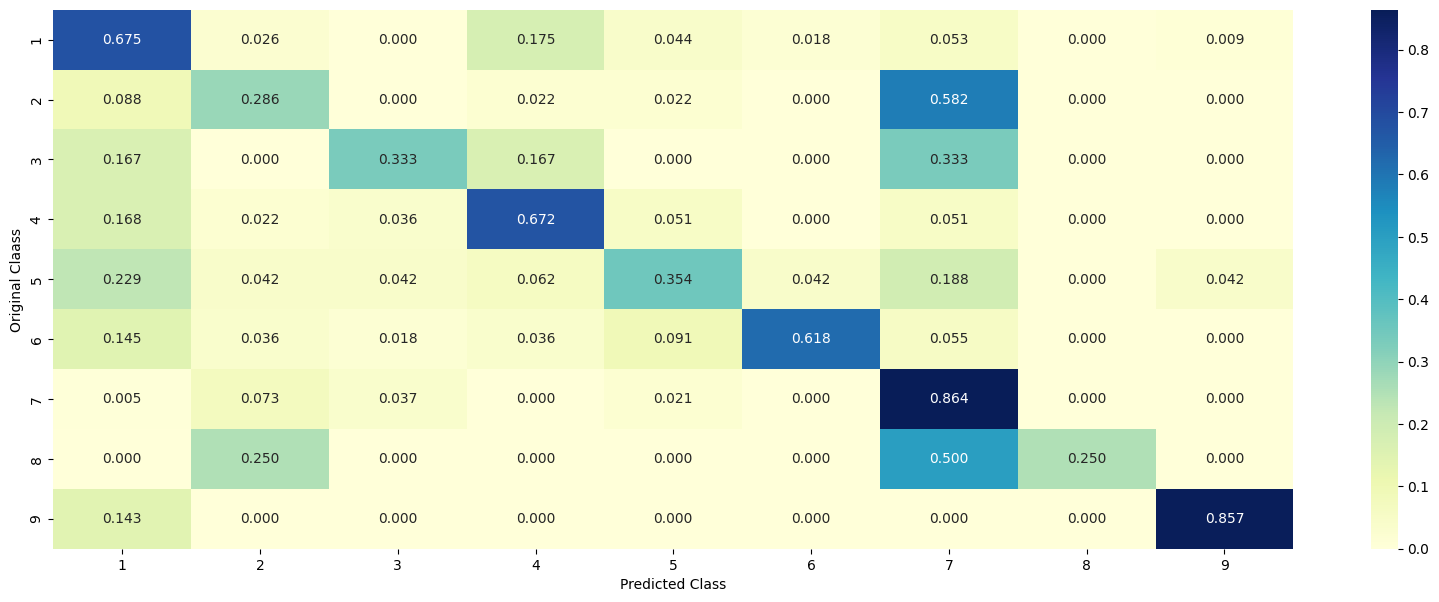

In [ ]:
from sklearn.ensemble import VotingClassifier
vclf=VotingClassifier(estimators=[('lr',sig_clf1),('svc',sig_clf2),('NB',sig_clf3)],voting='soft')
vclf.fit(x_train_ohe,y_train)
log_error=log_loss(y_train,vclf.predict_proba(x_train_ohe))
print("Train log loss is",log_error)
log_error=log_loss(y_cv,vclf.predict_proba(x_cv_ohe))
print("Cross Validation log loss is",log_error)
log_error=log_loss(y_test,vclf.predict_proba(x_test_ohe))
print("Test log loss is",log_error)

print("No of misclassified points",np.count_nonzero((y_test-vclf.predict(x_test_ohe)))/y_test.shape[0])
plot_confusion_matrix(y_test,vclf.predict(x_test_ohe))

## **Some Alternatives to reduce Log loss**

In [ ]:
gene=CountVectorizer(ngram_range=(1,2))
x_gene_train=gene.fit_transform(x_train['Gene'])
x_gene_test=gene.transform(x_test['Gene'])
x_gene_cv=gene.transform(x_cv['Gene'])

var=CountVectorizer(ngram_range=(1,2))
x_var_train=var.fit_transform(x_train['Variation'])
x_var_test=var.transform(x_test['Variation'])
x_var_cv=var.transform(x_cv['Variation'])

txt=CountVectorizer(ngram_range=(1,2))
x_txt_train=txt.fit_transform(x_train['Text'])
x_txt_test=txt.transform(x_test['Text'])
x_txt_cv=txt.transform(x_cv['Text'])

x_train_ohe=hstack((x_gene_train,x_var_train,x_txt_train)).tocsr()
x_test_ohe=hstack((x_gene_test,x_var_test,x_txt_test)).tocsr()
x_cv_ohe=hstack((x_gene_cv,x_var_cv,x_txt_cv)).tocsr()

In [ ]:
print("ONE HOT ENCODING USING N-GRAMS")
print("Train data",x_train_ohe.shape)
print("Test data",x_test_ohe.shape)
print("CV data",x_cv_ohe.shape)

ONE HOT ENCODING USING N-GRAMS
Train data (2124, 2347104)
Test data (665, 2347104)
CV data (532, 2347104)


For values of alpha:  1e-05  Log loss is:  1.8308895984571567
For values of alpha:  0.0001  Log loss is:  1.8308895984571567
For values of alpha:  0.001  Log loss is:  1.3326321375867771
For values of alpha:  0.01  Log loss is:  1.288324512830357
For values of alpha:  0.1  Log loss is:  1.28071354388059
For values of alpha:  1  Log loss is:  1.1757203605372277
For values of alpha:  10  Log loss is:  1.1559412976670134
For values of alpha:  100  Log loss is:  1.28523377654199


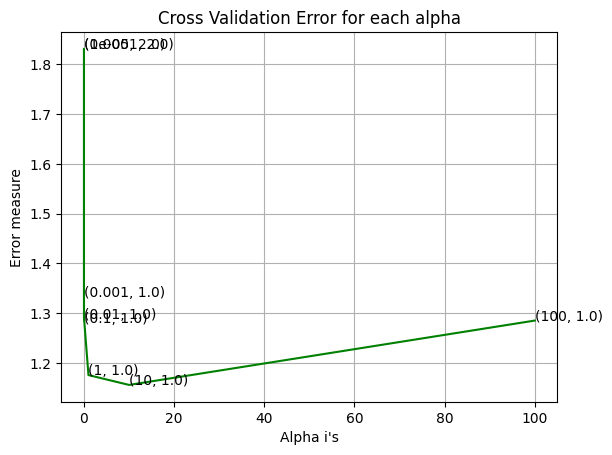

For values of best alpha  10  Train log loss is:  0.8488637344425812
For values of best alpha  10  Cross Validation log loss is:  1.1559412976670134
For values of best alpha  10  Test log loss is:  1.1458739599135879
Confusion Matrix


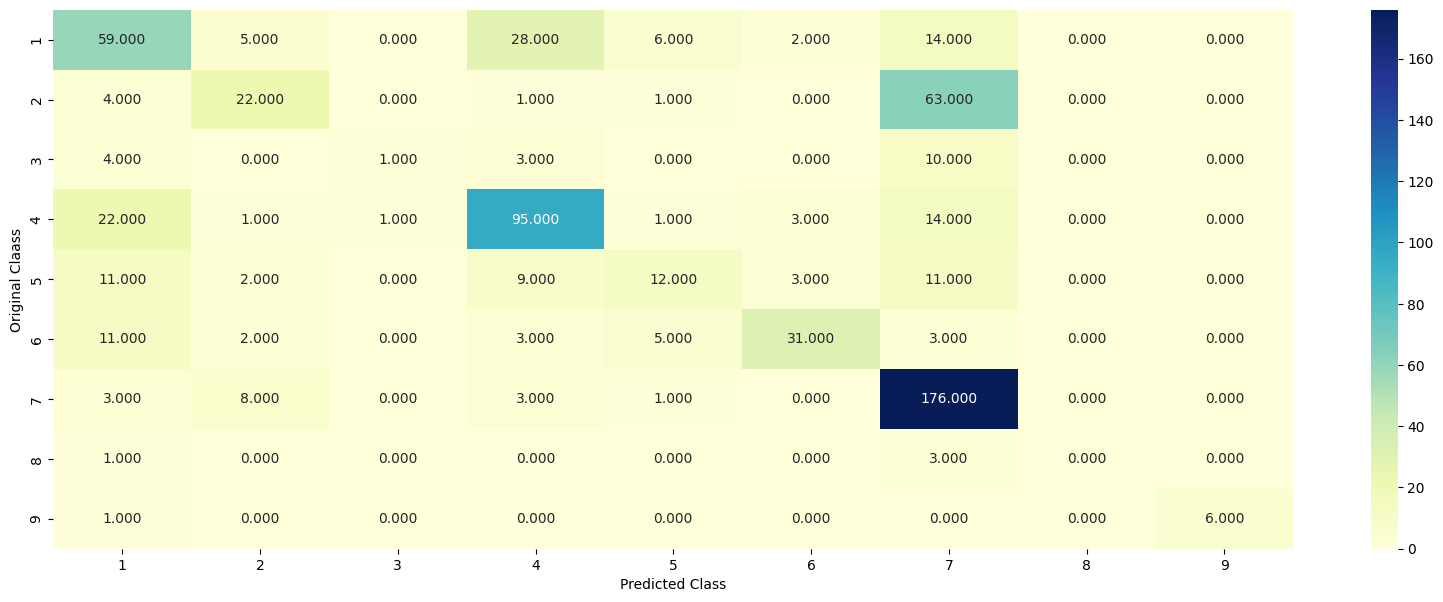

Precision Matrix (Column sum=1)


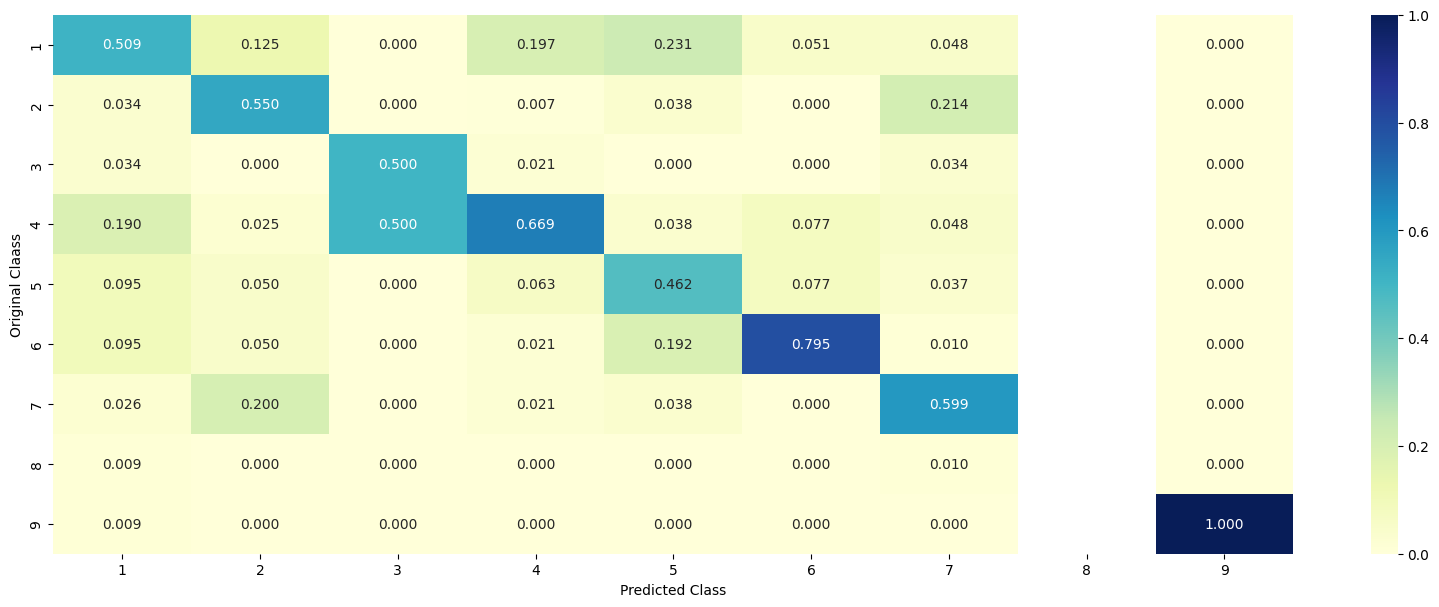

Recall Matrix (Row sum=1)


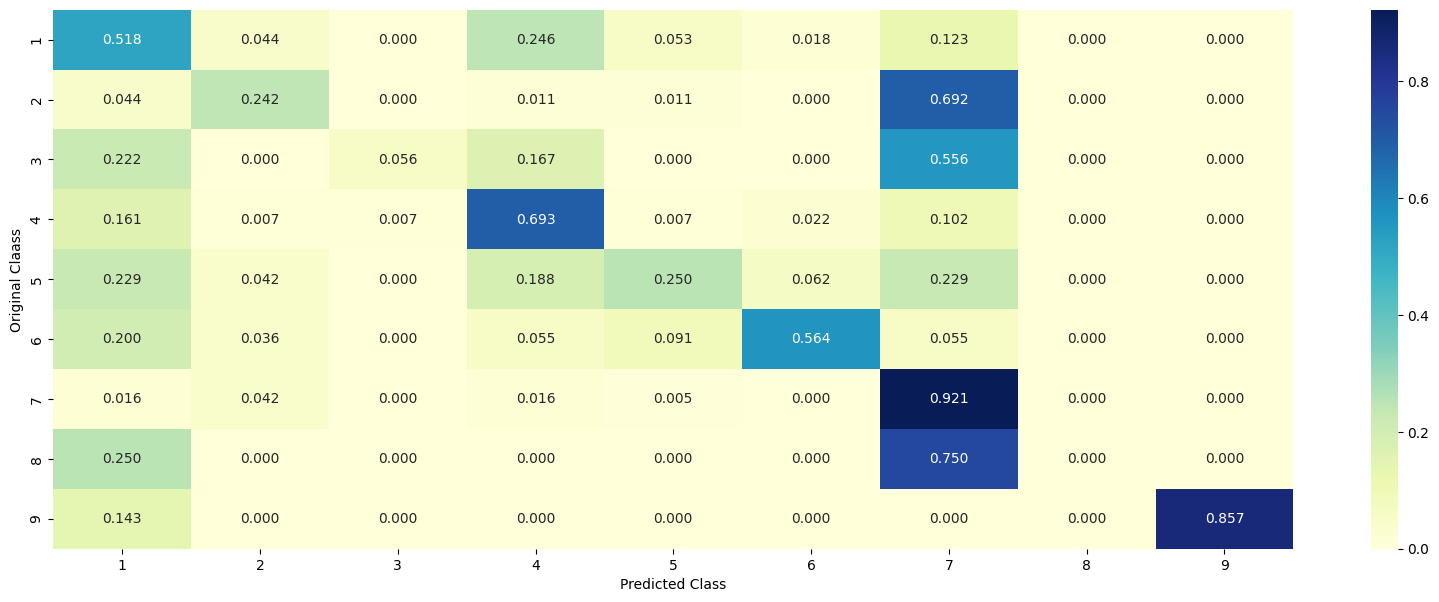

In [ ]:
alpha=[10**i for i in range(-5,3)]
predict_y,best_alpha=predicting_y(alpha,'log',x_train_ohe,x_cv_ohe,x_test_ohe,y_train,y_cv,y_test,'balanced')
plot_confusion_matrix(y_test,predict_y)

In [ ]:
gene=TfidfVectorizer(ngram_range=(1,2))
x_gene_train=gene.fit_transform(x_train['Gene'])
x_gene_test=gene.transform(x_test['Gene'])
x_gene_cv=gene.transform(x_cv['Gene'])

var=TfidfVectorizer(ngram_range=(1,2))
x_var_train=var.fit_transform(x_train['Variation'])
x_var_test=var.transform(x_test['Variation'])
x_var_cv=var.transform(x_cv['Variation'])

txt=TfidfVectorizer(ngram_range=(1,2))
x_txt_train=txt.fit_transform(x_train['Text'])
x_txt_test=txt.transform(x_test['Text'])
x_txt_cv=txt.transform(x_cv['Text'])

x_train_ohe=hstack((x_gene_train,x_var_train,x_txt_train)).tocsr()
x_test_ohe=hstack((x_gene_test,x_var_test,x_txt_test)).tocsr()
x_cv_ohe=hstack((x_gene_cv,x_var_cv,x_txt_cv)).tocsr()

In [ ]:
print("ONE HOT ENCODING USING N-GRAMS")
print("Train data",x_train_ohe.shape)
print("Test data",x_test_ohe.shape)
print("CV data",x_cv_ohe.shape)

ONE HOT ENCODING USING N-GRAMS
Train data (2124, 2391985)
Test data (665, 2391985)
CV data (532, 2391985)


For values of alpha:  1e-05  Log loss is:  0.9875390437012223
For values of alpha:  0.001  Log loss is:  1.0183019510333382
For values of alpha:  0.1  Log loss is:  1.3654300888324855
For values of alpha:  10  Log loss is:  1.4698262479224597


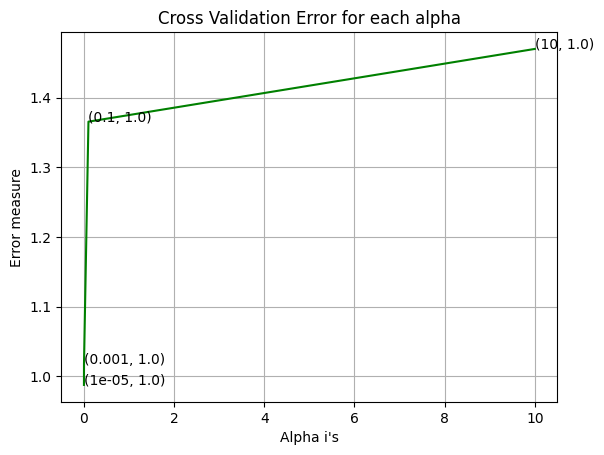

For values of best alpha  1e-05  Train log loss is:  0.3190780447067044
For values of best alpha  1e-05  Cross Validation log loss is:  0.9875390437012223
For values of best alpha  1e-05  Test log loss is:  1.004237153037683
Confusion Matrix


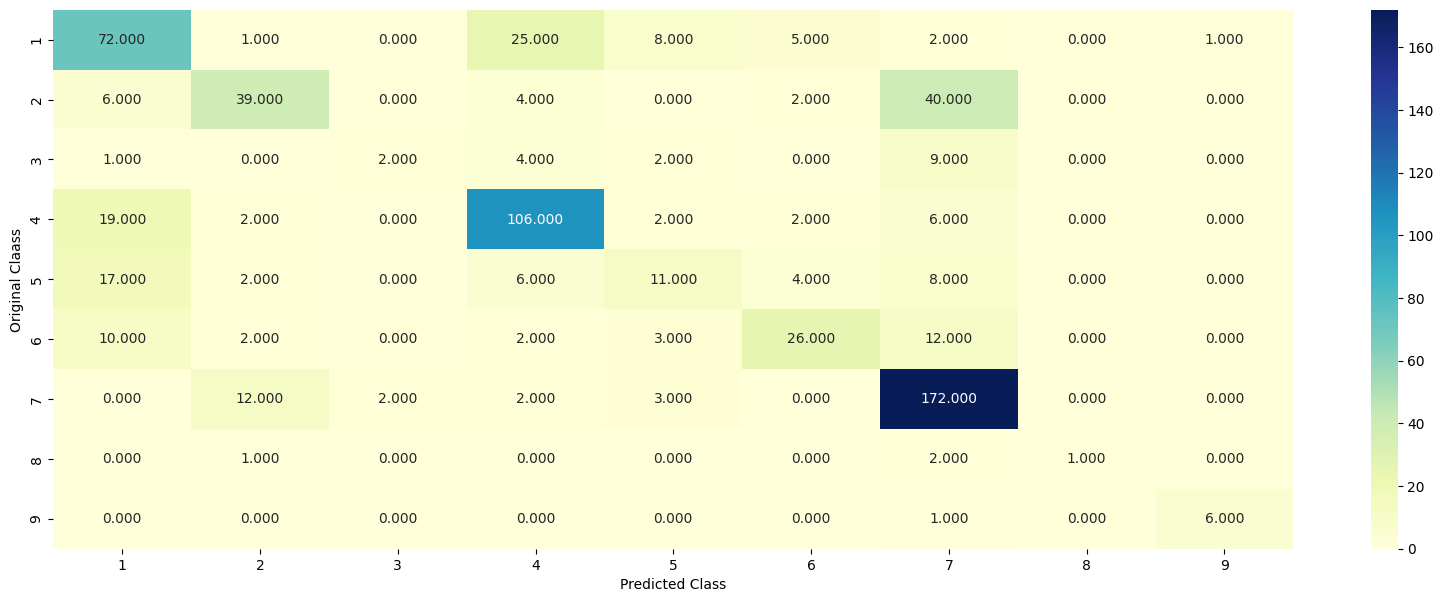

Precision Matrix (Column sum=1)


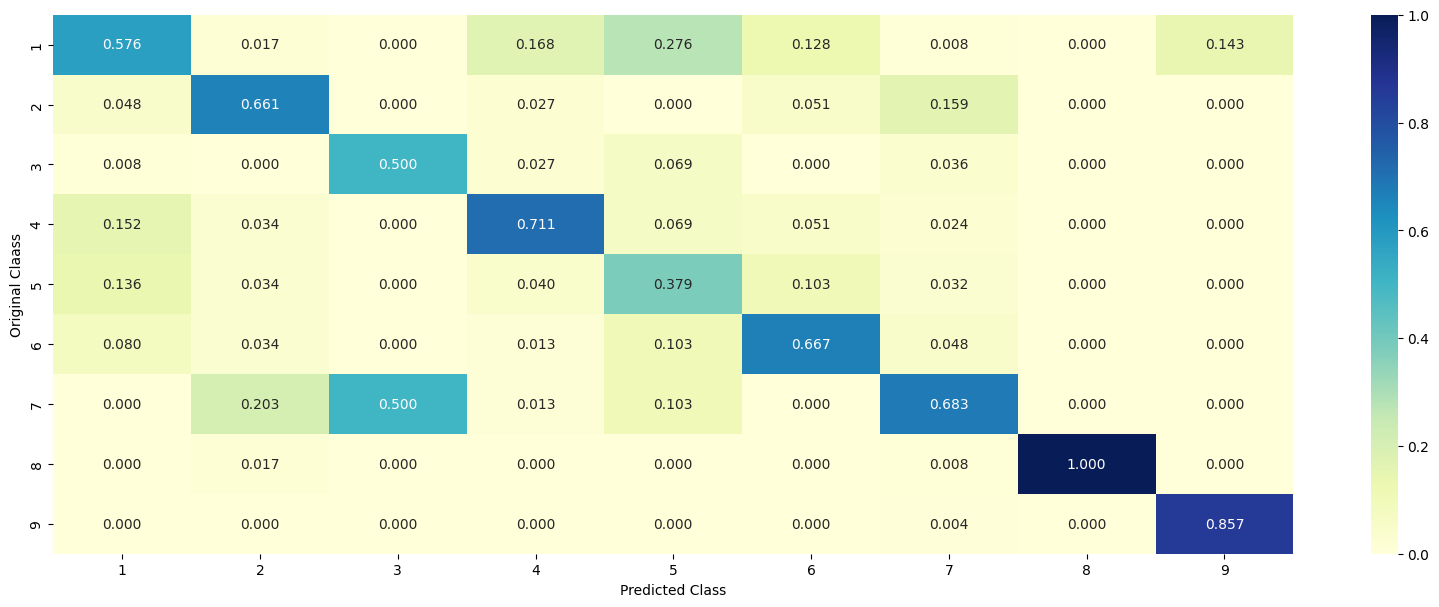

Recall Matrix (Row sum=1)


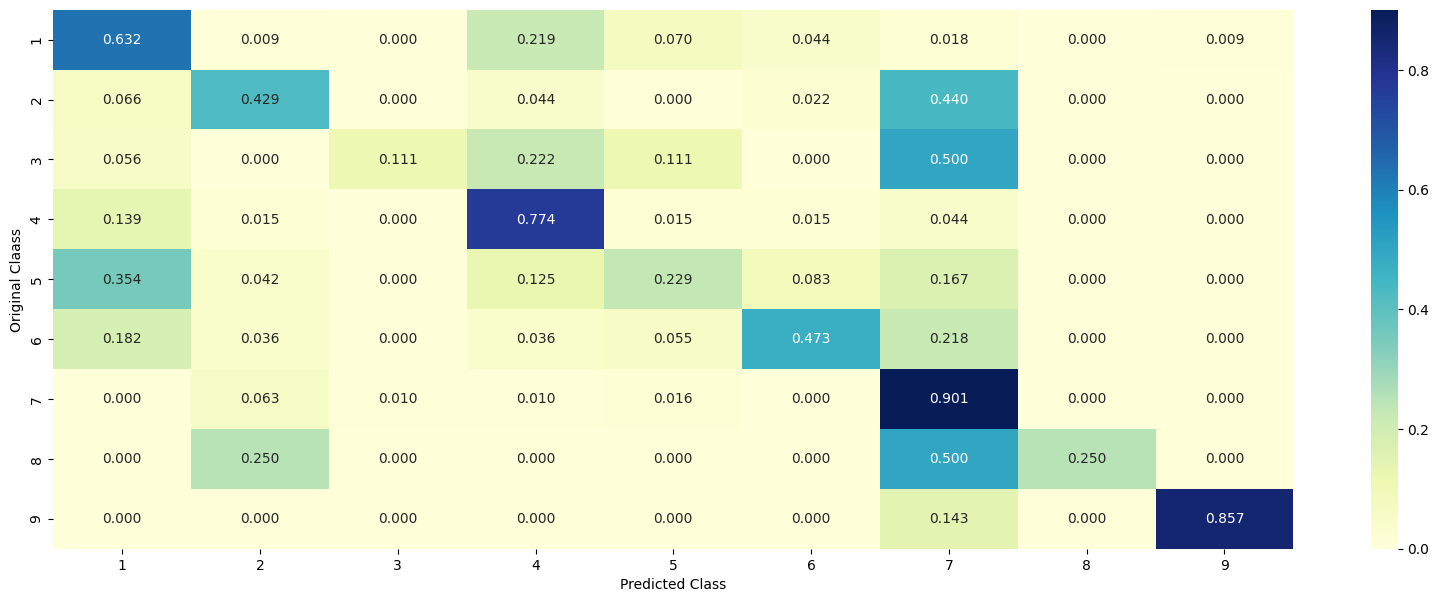

In [ ]:
alpha=[10**i for i in range(-5,3,2)]
predict_y,best_alpha=predicting_y(alpha,'log',x_train_ohe,x_cv_ohe,x_test_ohe,y_train,y_cv,y_test,'balanced')
plot_confusion_matrix(y_test,predict_y)

In [ ]:
gene=TfidfVectorizer(ngram_range=(1,3))
x_gene_train=gene.fit_transform(x_train['Gene'])
x_gene_test=gene.transform(x_test['Gene'])
x_gene_cv=gene.transform(x_cv['Gene'])

var=TfidfVectorizer(ngram_range=(1,3))
x_var_train=var.fit_transform(x_train['Variation'])
x_var_test=var.transform(x_test['Variation'])
x_var_cv=var.transform(x_cv['Variation'])

txt=TfidfVectorizer(ngram_range=(1,3))
x_txt_train=txt.fit_transform(x_train['Text'])
x_txt_test=txt.transform(x_test['Text'])
x_txt_cv=txt.transform(x_cv['Text'])

x_train_ohe=hstack((x_gene_train,x_var_train,x_txt_train)).tocsr()
x_test_ohe=hstack((x_gene_test,x_var_test,x_txt_test)).tocsr()
x_cv_ohe=hstack((x_gene_cv,x_var_cv,x_txt_cv)).tocsr()

print("ONE HOT ENCODING USING TRI-GRAMS")
print("Train data",x_train_ohe.shape)
print("Test data",x_test_ohe.shape)
print("CV data",x_cv_ohe.shape)

ONE HOT ENCODING USING TRI-GRAMS
Train data (2124, 7063833)
Test data (665, 7063833)
CV data (532, 7063833)


For values of alpha:  1e-05  Log loss is:  0.9882629229794864
For values of alpha:  0.001  Log loss is:  1.01572798009445
For values of alpha:  0.1  Log loss is:  1.3505982950323543
For values of alpha:  10  Log loss is:  1.4496786466163119


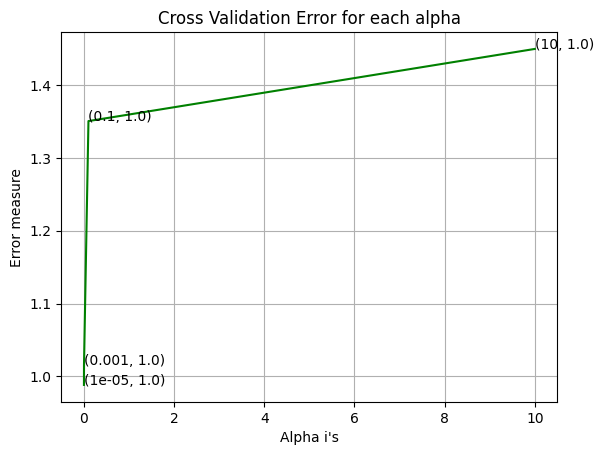

For values of best alpha  1e-05  Train log loss is:  0.31623719318539645
For values of best alpha  1e-05  Cross Validation log loss is:  0.9882629229794864
For values of best alpha  1e-05  Test log loss is:  1.0016995798303003
Confusion Matrix


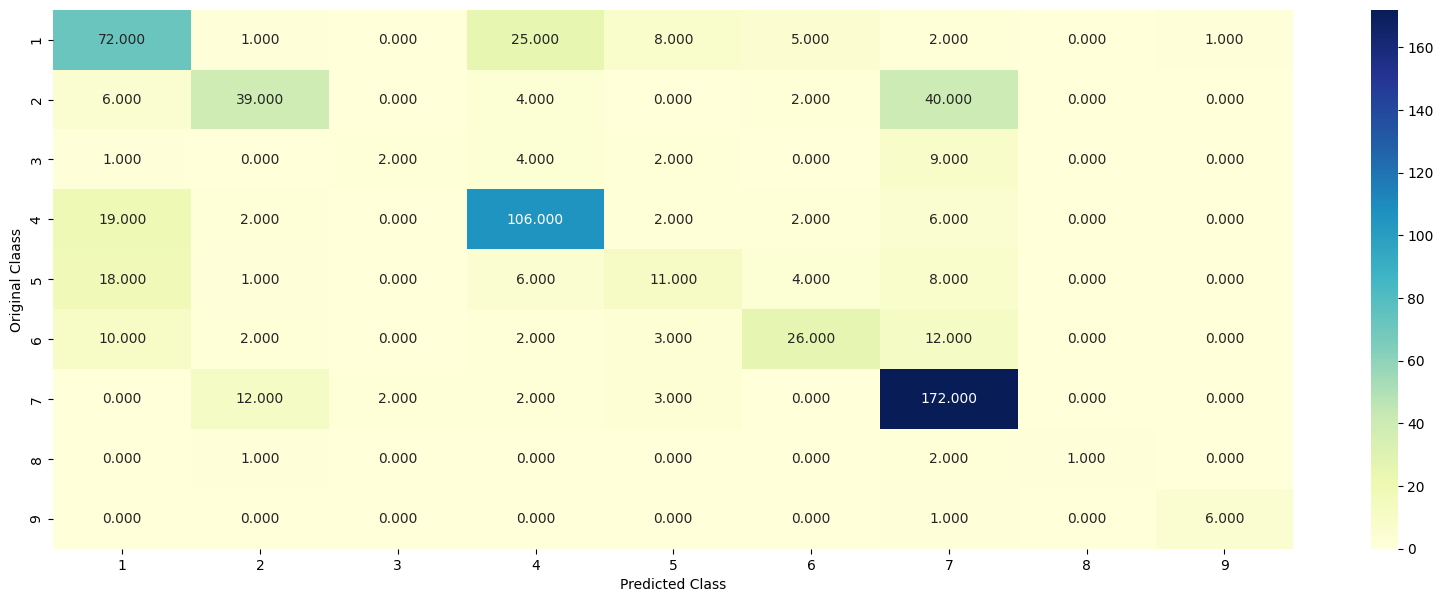

Precision Matrix (Column sum=1)


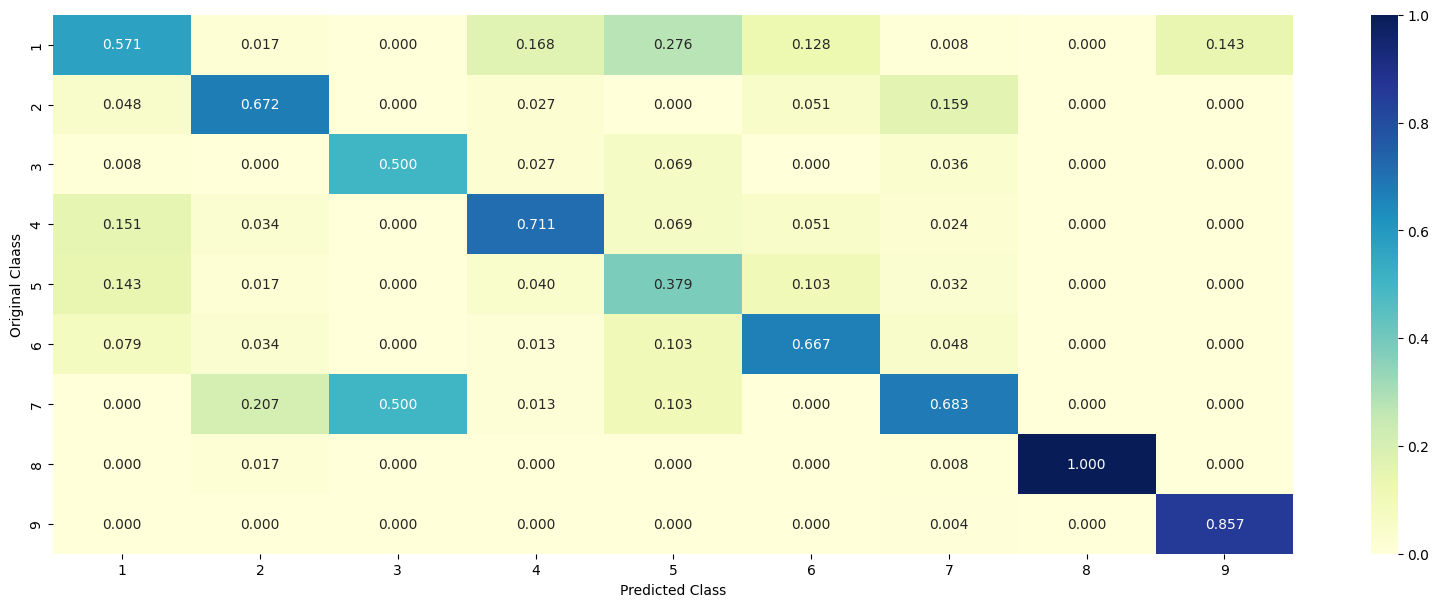

Recall Matrix (Row sum=1)


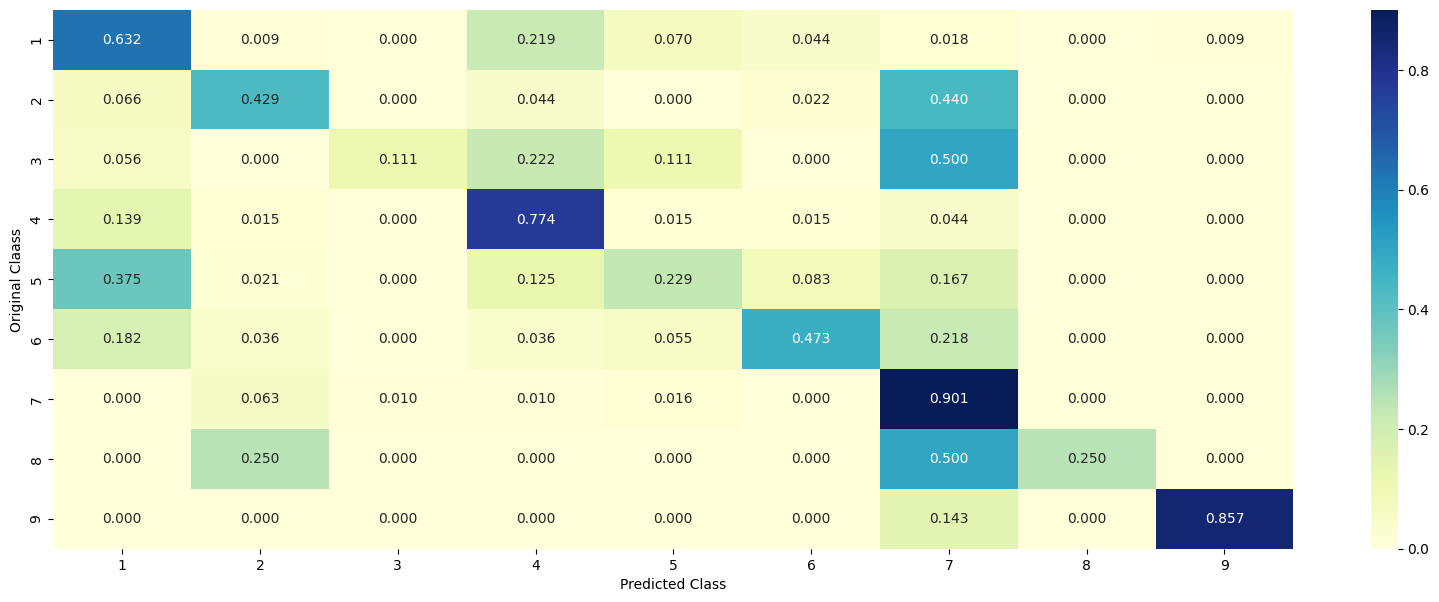

In [ ]:
alpha=[10**i for i in range(-5,3,2)]
predict_y,best_alpha=predicting_y(alpha,'log',x_train_ohe,x_cv_ohe,x_test_ohe,y_train,y_cv,y_test,'balanced')
plot_confusion_matrix(y_test,predict_y)

In [ ]:
gene=TfidfVectorizer(ngram_range=(1,2),max_features=100000)
x_gene_train=gene.fit_transform(x_train['Gene'])
x_gene_test=gene.transform(x_test['Gene'])
x_gene_cv=gene.transform(x_cv['Gene'])

var=TfidfVectorizer(ngram_range=(1,2),max_features=100000)
x_var_train=var.fit_transform(x_train['Variation'])
x_var_test=var.transform(x_test['Variation'])
x_var_cv=var.transform(x_cv['Variation'])

txt=TfidfVectorizer(ngram_range=(1,2),max_features=100000)
x_txt_train=txt.fit_transform(x_train['Text'])
x_txt_test=txt.transform(x_test['Text'])
x_txt_cv=txt.transform(x_cv['Text'])

x_train_ohe=hstack((x_gene_train,x_var_train,x_txt_train)).tocsr()
x_test_ohe=hstack((x_gene_test,x_var_test,x_txt_test)).tocsr()
x_cv_ohe=hstack((x_gene_cv,x_var_cv,x_txt_cv)).tocsr()

print("ONE HOT ENCODING USING Max features")
print("Train data",x_train_ohe.shape)
print("Test data",x_test_ohe.shape)
print("CV data",x_cv_ohe.shape)

ONE HOT ENCODING USING Max features
Train data (2124, 102365)
Test data (665, 102365)
CV data (532, 102365)


For values of alpha:  1e-06  Log loss is:  1.1071144489712217
For values of alpha:  1e-05  Log loss is:  0.9804415521085811
For values of alpha:  0.0001  Log loss is:  0.9599657097821842
For values of alpha:  0.001  Log loss is:  1.0176285750187575
For values of alpha:  0.01  Log loss is:  1.1631332698095007
For values of alpha:  0.1  Log loss is:  1.3703570095164703
For values of alpha:  1  Log loss is:  1.462605099614473
For values of alpha:  10  Log loss is:  1.4758190773816635
For values of alpha:  100  Log loss is:  1.4774423842954076


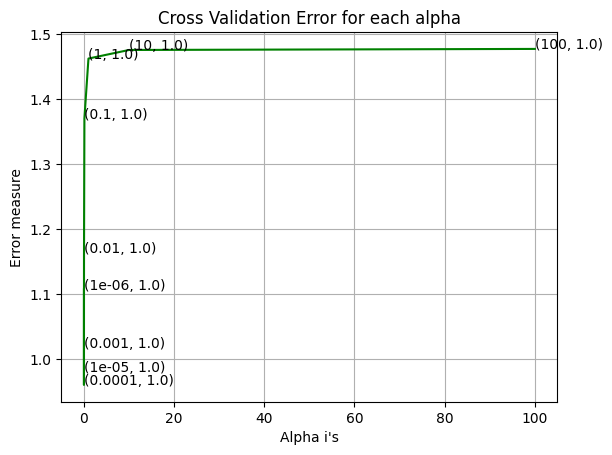

For values of best alpha  0.0001  Train log loss is:  0.3559905571167076
For values of best alpha  0.0001  Cross Validation log loss is:  0.9599657097821842
For values of best alpha  0.0001  Test log loss is:  0.9764762272644417
Confusion Matrix


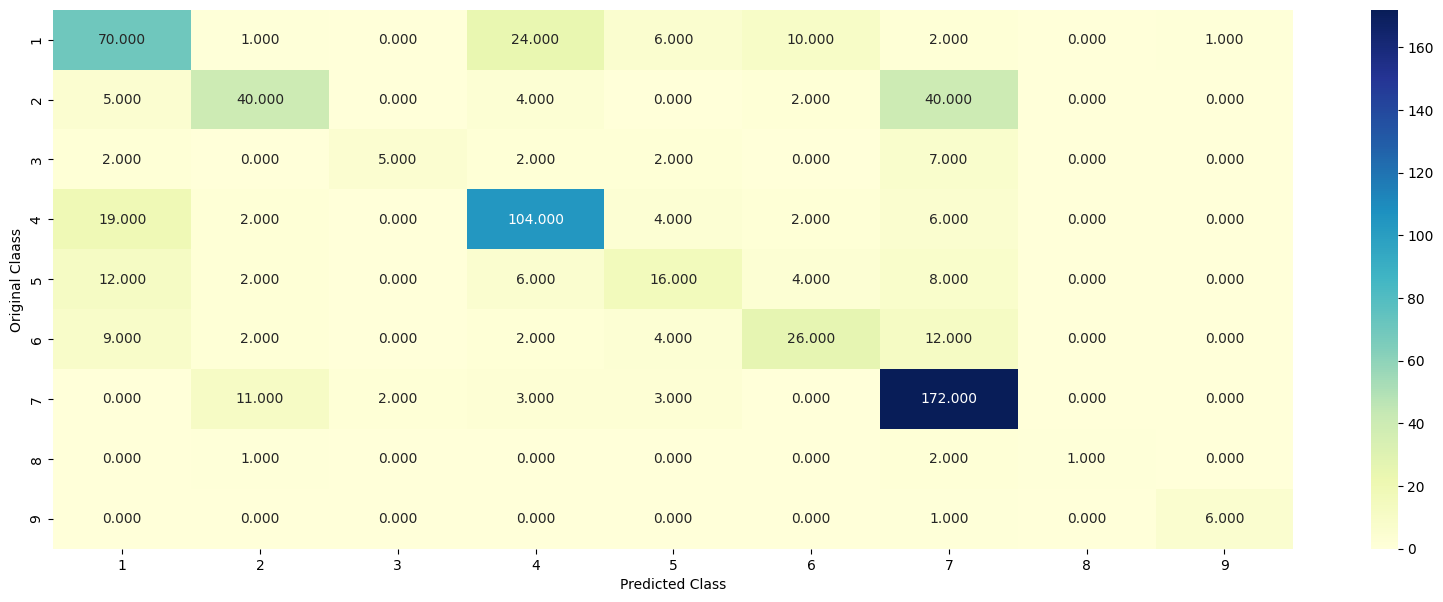

Precision Matrix (Column sum=1)


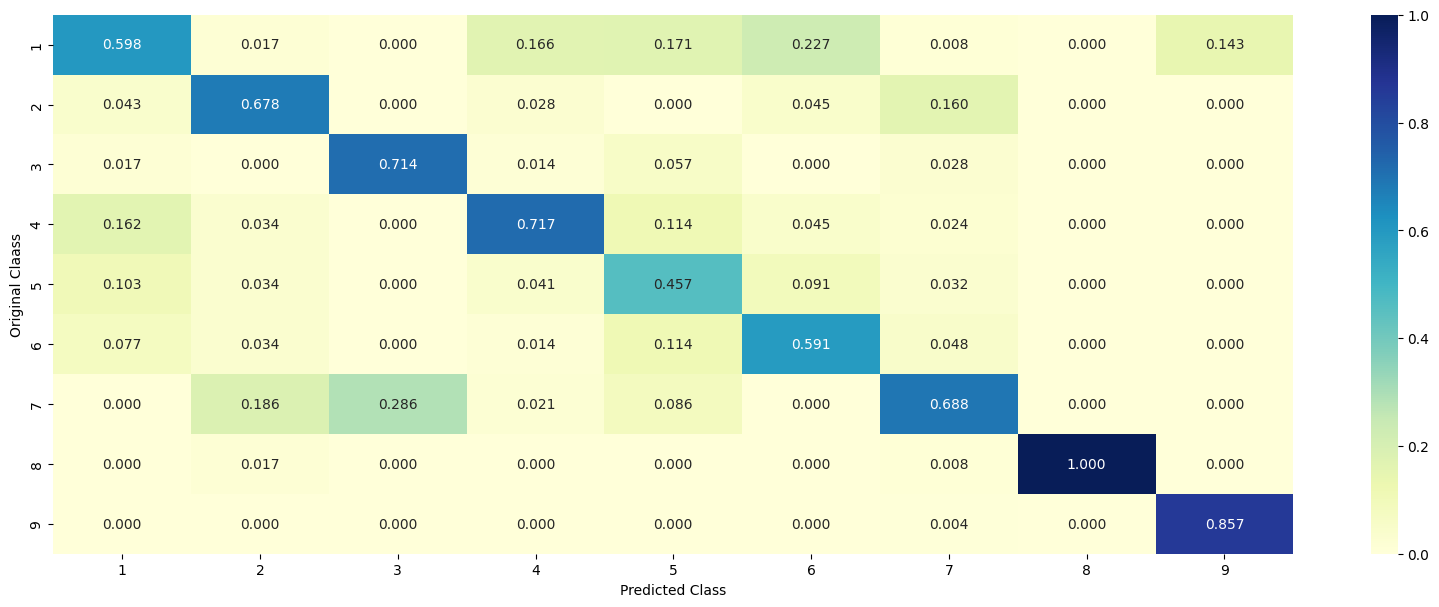

Recall Matrix (Row sum=1)


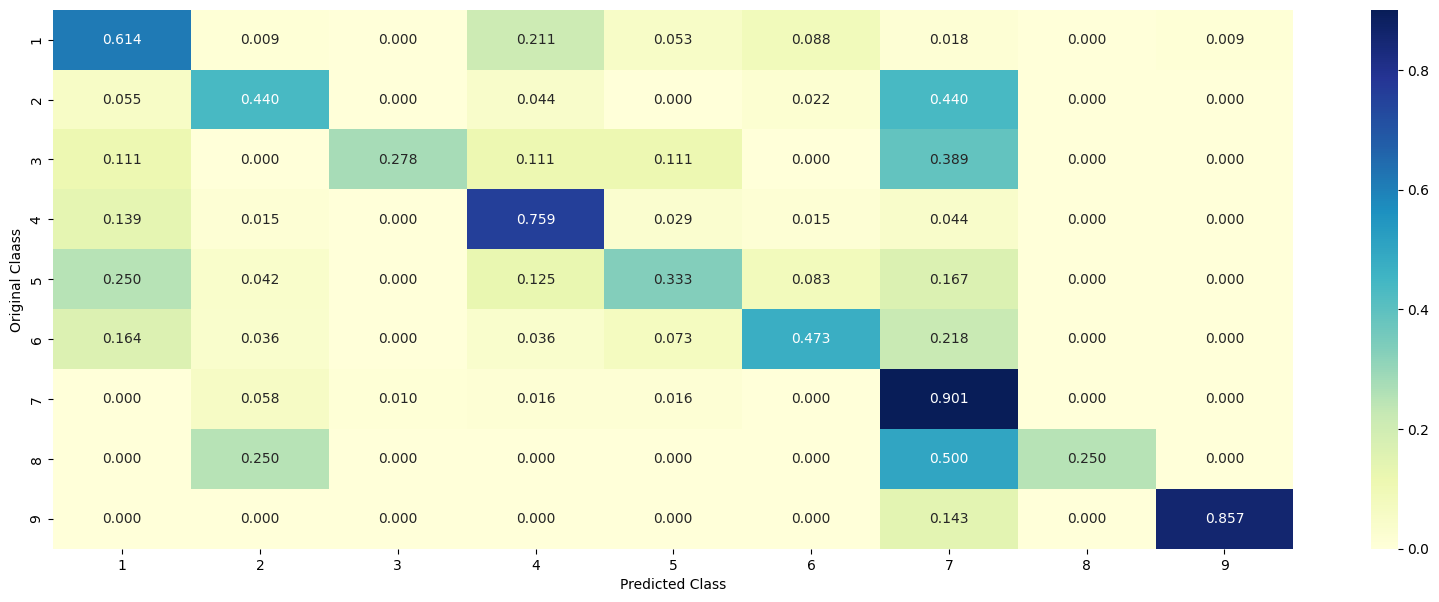

In [ ]:
alpha=[10**i for i in range(-6,3)]
predict_y,best_alpha=predicting_y(alpha,'log',x_train_ohe,x_cv_ohe,x_test_ohe,y_train,y_cv,y_test,'balanced')
plot_confusion_matrix(y_test,predict_y)